# GPL Paper Section 4.1.2 Experiment: Quadratic Hamiltonian with L1 Prior

This code attempts to learn 32D prior $J(x) = \|x\|_1$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian
$H(p) = \frac{1}{2}\|p\|_2^2$ (Using the method of characterization).
The LPN learns the function $\psi(y) = J^*(y) - \frac{1}{2}\|y\|_2^2$.
Training data uses samples $\{y_j,\psi(y_j)\}$ where $\psi(y_j) = \frac{1}{2}\|y_j\|_2^2 - S(y_j,1)$, and,
$S(y_j,1) = \min_{x \in \mathbb{R}^d} \{\frac{1}{2}\|x-y_j\|_2^2 + \|x\|_1\}$ (Moreau envelope of $J(x)=\|x\|_1$ at $t=1$).

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_4_1_2_quadratic_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters for Sec 4.1.2 L1 Prior Experiment ---
dim_exp = 32  
data_points_exp = 40000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
#eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)

def prox_l1_vec(y, t_lambda):
    """ Element-wise proximal operator of t_lambda*||x||_1 (soft-thresholding). """
    return np.sign(y) * np.maximum(np.abs(y) - t_lambda, 0)

def hjsol_true_quadratic_l1(y_points,n=1.0, t=1.0): # y_points is N x dim
    """
    Computes S(y, t=1) for J(x)=||x||_1.
    S(y, 1) = ||x||_1 + nt/2 }
    """
    t_moreau = 1.0
    prox_y = prox_l1_vec(y_points, t_moreau) # element-wise for N x dim
    s_values = np.sum(np.abs(prox_y), axis=1) +n * t/2 # L1 norm for each vector y_j 
    return s_values # N-dimensional array

def prior_true_quadratic_l1(y_points): # y_points is N x dim
    """ Computes the true prior J(y) = ||y||_1. """
    return np.sum(np.abs(y_points), axis=1) # N-dimensional array

def cvx_true_quadratic_l1(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = 0.5*||y||_2^2 - S(y, t=1) for J(x)=||x||_1.
    """
    s_y_1 = hjsol_true_quadratic_l1(y_points)
    psi_y = 0.5 * euclid_norm_sq(y_points) - s_y_1
    return psi_y # N-dimensional array

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est

def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_quadratic_l1(x1_0_points)
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_quadratic_l1(x2_0_points)
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim={dim}) ---")
    cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim)



In [4]:

def exp_func(x, gamma):
    # Ensure x is a 1D tensor for vector_norm if it comes in as N x 1
    if x.ndim > 1 and x.shape[1] == 1:
        x = x.squeeze(1)
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim=-1)/ gamma) ** 2)) + 1.0

# --- Generate Training Data (using Moreau envelope target as per notebook) ---

In [5]:
# --- Generate Training Data ---
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))

cvx_samples_exp_np = cvx_true_quadratic_l1(y_j_exp_np)
cvx_samples_exp_np = cvx_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float()
cvx_samples_exp_tensor = torch.from_numpy(cvx_samples_exp_np).float()
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, cvx_samples_exp_tensor shape {cvx_samples_exp_tensor.shape}")
# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
cvx_samples_exp_tensor = cvx_samples_exp_tensor.to(device)

Generated training data: y_j_exp_tensor shape torch.Size([40000, 32]), cvx_samples_exp_tensor shape torch.Size([40000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L1 loss -- Train

In [7]:

print("--- Training LPN for J(x)=||x||_1 (Quadratic H) ---")
lpn_model_quad_l1 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_quad_l1 = torch.optim.Adam(lpn_model_quad_l1.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

for g in optimizer_quad_l1.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_quad_l1.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

torch.save(lpn_model_quad_l1.state_dict(), os.path.join(MODEL_DIR, "QuadraticH_L1prior_l1.pth"))

--- Training LPN for J(x)=||x||_1 (Quadratic H) ---


iteration 0 loss 48.40913009643555
iteration 0 loss 11.328652381896973


iteration 500 loss 3.497055768966675


iteration 1000 loss 3.346701145172119


iteration 1500 loss 3.194692373275757


iteration 2000 loss 3.0065600872039795


iteration 2500 loss 2.7584972381591797


iteration 3000 loss 2.392504930496216


iteration 3500 loss 1.805761456489563


iteration 4000 loss 1.1513131856918335


iteration 4500 loss 0.9063557386398315


iteration 5000 loss 0.8167805075645447


iteration 5500 loss 0.7628929615020752


iteration 6000 loss 0.7250975370407104


iteration 6500 loss 0.6944007277488708


iteration 7000 loss 0.6736587882041931


iteration 7500 loss 0.6483464241027832


iteration 8000 loss 0.6402097940444946


iteration 8500 loss 0.613125205039978


iteration 9000 loss 0.6072931289672852


iteration 9500 loss 0.5892854332923889


iteration 10000 loss 0.5844353437423706


iteration 10500 loss 0.5755278468132019


iteration 11000 loss 0.5527475476264954


iteration 11500 loss 0.5449696779251099


iteration 12000 loss 0.5442273616790771


iteration 12500 loss 0.5268744826316833


iteration 13000 loss 0.5209067463874817


iteration 13500 loss 0.5117114186286926


iteration 14000 loss 0.507788360118866


iteration 14500 loss 0.4969223439693451


iteration 15000 loss 0.5009644627571106


iteration 15500 loss 0.4871027171611786


iteration 16000 loss 0.4912724494934082


iteration 16500 loss 0.4729446768760681


iteration 17000 loss 0.4685993194580078


iteration 17500 loss 0.4690067172050476


iteration 18000 loss 0.4624095559120178


iteration 18500 loss 0.4668271243572235


iteration 19000 loss 0.46349194645881653


iteration 19500 loss 0.4462035000324249


iteration 20000 loss 0.44257888197898865


iteration 20500 loss 0.4494590163230896


iteration 21000 loss 0.4476701021194458


iteration 21500 loss 0.4277569353580475


iteration 22000 loss 0.4242567718029022


iteration 22500 loss 0.42381981015205383


iteration 23000 loss 0.4259386658668518


iteration 23500 loss 0.41423192620277405


iteration 24000 loss 0.4123533070087433


iteration 24500 loss 0.4098491966724396


iteration 25000 loss 0.4202831983566284


iteration 25500 loss 0.41774001717567444


iteration 26000 loss 0.41507387161254883


iteration 26500 loss 0.4152487814426422


iteration 27000 loss 0.39466196298599243


iteration 27500 loss 0.4080713391304016


iteration 28000 loss 0.3941367566585541


iteration 28500 loss 0.38877585530281067


iteration 29000 loss 0.4030943810939789


iteration 29500 loss 0.3919696807861328


iteration 30000 loss 0.3961048126220703


iteration 30500 loss 0.39566537737846375


iteration 31000 loss 0.3762666881084442


iteration 31500 loss 0.39088913798332214


iteration 32000 loss 0.37318456172943115


iteration 32500 loss 0.37948474287986755


iteration 33000 loss 0.37627506256103516


iteration 33500 loss 0.38023972511291504


iteration 34000 loss 0.3671623170375824


iteration 34500 loss 0.3680603504180908


iteration 35000 loss 0.3775098919868469


iteration 35500 loss 0.37652787566185


iteration 36000 loss 0.357590913772583


iteration 36500 loss 0.3711986541748047


iteration 37000 loss 0.36170199513435364


iteration 37500 loss 0.3589611351490021


iteration 38000 loss 0.34956908226013184


iteration 38500 loss 0.3477659523487091


iteration 39000 loss 0.34707847237586975


iteration 39500 loss 0.3617266118526459


iteration 40000 loss 0.35308319330215454


iteration 40500 loss 0.3503649830818176


iteration 41000 loss 0.3419803977012634


iteration 41500 loss 0.3543020486831665


iteration 42000 loss 0.3501337766647339


iteration 42500 loss 0.34807446599006653


iteration 43000 loss 0.3530505299568176


iteration 43500 loss 0.3393479585647583


iteration 44000 loss 0.3368699252605438


iteration 44500 loss 0.3319578468799591


iteration 45000 loss 0.3318857252597809


iteration 45500 loss 0.3335045278072357


iteration 46000 loss 0.3406223952770233


iteration 46500 loss 0.32937246561050415


iteration 47000 loss 0.335954874753952


iteration 47500 loss 0.3405194878578186


iteration 48000 loss 0.33730271458625793


iteration 48500 loss 0.34049612283706665


iteration 49000 loss 0.3287619650363922


iteration 49500 loss 0.3202837407588959


iteration 50000 loss 0.3275815546512604


iteration 50500 loss 0.33214545249938965


iteration 51000 loss 0.3226386606693268


iteration 51500 loss 0.32140183448791504


iteration 52000 loss 0.3319952189922333


iteration 52500 loss 0.33265888690948486


iteration 53000 loss 0.3313444256782532


iteration 53500 loss 0.315504252910614


iteration 54000 loss 0.320299357175827


iteration 54500 loss 0.3146757185459137


iteration 55000 loss 0.3128097653388977


iteration 55500 loss 0.31300365924835205


iteration 56000 loss 0.32453852891921997


iteration 56500 loss 0.3080354928970337


iteration 57000 loss 0.32271695137023926


iteration 57500 loss 0.31588682532310486


iteration 58000 loss 0.3090646266937256


iteration 58500 loss 0.3240284025669098


iteration 59000 loss 0.32117438316345215


iteration 59500 loss 0.3166539967060089


iteration 60000 loss 0.3187553882598877


iteration 60500 loss 0.3137299120426178


iteration 61000 loss 0.3044288754463196


iteration 61500 loss 0.3187657594680786


iteration 62000 loss 0.2989218831062317


iteration 62500 loss 0.3077583909034729


iteration 63000 loss 0.30696335434913635


iteration 63500 loss 0.295747309923172


iteration 64000 loss 0.314212828874588


iteration 64500 loss 0.30795007944107056


iteration 65000 loss 0.2988247275352478


iteration 65500 loss 0.3125399649143219


iteration 66000 loss 0.3040177524089813


iteration 66500 loss 0.3051525354385376


iteration 67000 loss 0.2949103116989136


iteration 67500 loss 0.3011784255504608


iteration 68000 loss 0.30352139472961426


iteration 68500 loss 0.29169249534606934


iteration 69000 loss 0.29100462794303894


iteration 69500 loss 0.3090793192386627


iteration 70000 loss 0.3000067174434662


iteration 70500 loss 0.2911078631877899


iteration 71000 loss 0.285512238740921


iteration 71500 loss 0.29259634017944336


iteration 72000 loss 0.2948908507823944


iteration 72500 loss 0.2992693781852722


iteration 73000 loss 0.28296035528182983


iteration 73500 loss 0.28956979513168335


iteration 74000 loss 0.28584790229797363


iteration 74500 loss 0.2996104955673218


iteration 75000 loss 0.28121131658554077


iteration 75500 loss 0.2965720295906067


iteration 76000 loss 0.29252973198890686


iteration 76500 loss 0.28080883622169495


iteration 77000 loss 0.28216904401779175


iteration 77500 loss 0.29311802983283997


iteration 78000 loss 0.2981506288051605


iteration 78500 loss 0.2808169722557068


iteration 79000 loss 0.2771305441856384


iteration 79500 loss 0.27720722556114197


iteration 80000 loss 0.2921854853630066


iteration 80500 loss 0.2825976610183716


iteration 81000 loss 0.2918230891227722


iteration 81500 loss 0.273712694644928


iteration 82000 loss 0.2829175591468811


iteration 82500 loss 0.2729029357433319


iteration 83000 loss 0.28664717078208923


iteration 83500 loss 0.2716625928878784


iteration 84000 loss 0.2869071662425995


iteration 84500 loss 0.27179139852523804


iteration 85000 loss 0.27354928851127625


iteration 85500 loss 0.2697364389896393


iteration 86000 loss 0.2748759090900421


iteration 86500 loss 0.2864162027835846


iteration 87000 loss 0.26932212710380554


iteration 87500 loss 0.26781463623046875


iteration 88000 loss 0.2841379940509796


iteration 88500 loss 0.26967552304267883


iteration 89000 loss 0.26677119731903076


iteration 89500 loss 0.2837424874305725


iteration 90000 loss 0.2654787600040436


iteration 90500 loss 0.27929824590682983


iteration 91000 loss 0.2784290909767151


iteration 91500 loss 0.2813892364501953


iteration 92000 loss 0.28394192457199097


iteration 92500 loss 0.26864856481552124


iteration 93000 loss 0.27046966552734375


iteration 93500 loss 0.2648700475692749


iteration 94000 loss 0.26434803009033203


iteration 94500 loss 0.26400625705718994


iteration 95000 loss 0.26404622197151184


iteration 95500 loss 0.267805278301239


iteration 96000 loss 0.2794027030467987


iteration 96500 loss 0.2624458968639374


iteration 97000 loss 0.28381237387657166


iteration 97500 loss 0.26044222712516785


iteration 98000 loss 0.26020440459251404


iteration 98500 loss 0.2652532756328583


iteration 99000 loss 0.258579283952713


iteration 99500 loss 0.2629625201225281


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.25684279203414917


iteration 100500 loss 0.2547546327114105


iteration 101000 loss 0.2540157735347748


iteration 101500 loss 0.2537814676761627


iteration 102000 loss 0.2531319856643677


iteration 102500 loss 0.2532089352607727


iteration 103000 loss 0.25261861085891724


iteration 103500 loss 0.25207552313804626


iteration 104000 loss 0.2522381842136383


iteration 104500 loss 0.25097495317459106


iteration 105000 loss 0.250715970993042


iteration 105500 loss 0.2516743838787079


iteration 106000 loss 0.2504918873310089


iteration 106500 loss 0.25021687150001526


iteration 107000 loss 0.2510373890399933


iteration 107500 loss 0.25051918625831604


iteration 108000 loss 0.2509872317314148


iteration 108500 loss 0.25030210614204407


iteration 109000 loss 0.24951820075511932


iteration 109500 loss 0.24957235157489777


iteration 110000 loss 0.25115808844566345


iteration 110500 loss 0.2499319314956665


iteration 111000 loss 0.24934086203575134


iteration 111500 loss 0.24989193677902222


iteration 112000 loss 0.24949349462985992


iteration 112500 loss 0.24886111915111542


iteration 113000 loss 0.2494688481092453


iteration 113500 loss 0.24931378662586212


iteration 114000 loss 0.2483886182308197


iteration 114500 loss 0.24841095507144928


iteration 115000 loss 0.2490934580564499


iteration 115500 loss 0.24801437556743622


iteration 116000 loss 0.24934528768062592


iteration 116500 loss 0.24825569987297058


iteration 117000 loss 0.24857938289642334


iteration 117500 loss 0.24793793261051178


iteration 118000 loss 0.24782179296016693


iteration 118500 loss 0.24765419960021973


iteration 119000 loss 0.2487054169178009


iteration 119500 loss 0.24758727848529816


iteration 120000 loss 0.24768660962581635


iteration 120500 loss 0.24720712006092072


iteration 121000 loss 0.24746811389923096


iteration 121500 loss 0.24833543598651886


iteration 122000 loss 0.2472131997346878


iteration 122500 loss 0.24680550396442413


iteration 123000 loss 0.24704095721244812


iteration 123500 loss 0.24797239899635315


iteration 124000 loss 0.24706918001174927


iteration 124500 loss 0.24751248955726624


iteration 125000 loss 0.24744220077991486


iteration 125500 loss 0.2474726438522339


iteration 126000 loss 0.24743641912937164


iteration 126500 loss 0.24702660739421844


iteration 127000 loss 0.24720707535743713


iteration 127500 loss 0.24615734815597534


iteration 128000 loss 0.24633120000362396


iteration 128500 loss 0.24610982835292816


iteration 129000 loss 0.2467462122440338


iteration 129500 loss 0.24599598348140717


iteration 130000 loss 0.24720926582813263


iteration 130500 loss 0.24599960446357727


iteration 131000 loss 0.24646414816379547


iteration 131500 loss 0.24631816148757935


iteration 132000 loss 0.2457544356584549


iteration 132500 loss 0.24684710800647736


iteration 133000 loss 0.2463538944721222


iteration 133500 loss 0.24614818394184113


iteration 134000 loss 0.24689003825187683


iteration 134500 loss 0.24601249396800995


iteration 135000 loss 0.24595195055007935


iteration 135500 loss 0.24549327790737152


iteration 136000 loss 0.24658162891864777


iteration 136500 loss 0.24522006511688232


iteration 137000 loss 0.24587148427963257


iteration 137500 loss 0.24517640471458435


iteration 138000 loss 0.2451513558626175


iteration 138500 loss 0.24503280222415924


iteration 139000 loss 0.2447289526462555


iteration 139500 loss 0.2458524852991104


iteration 140000 loss 0.24592381715774536


iteration 140500 loss 0.24593348801136017


iteration 141000 loss 0.24604082107543945


iteration 141500 loss 0.24529147148132324


iteration 142000 loss 0.24549494683742523


iteration 142500 loss 0.24484476447105408


iteration 143000 loss 0.24451066553592682


iteration 143500 loss 0.24587377905845642


iteration 144000 loss 0.2442697435617447


iteration 144500 loss 0.2445884644985199


iteration 145000 loss 0.24537017941474915


iteration 145500 loss 0.24484257400035858


iteration 146000 loss 0.24399052560329437


iteration 146500 loss 0.24402675032615662


iteration 147000 loss 0.24415932595729828


iteration 147500 loss 0.24377231299877167


iteration 148000 loss 0.2437901794910431


iteration 148500 loss 0.2447357326745987


iteration 149000 loss 0.24536561965942383


iteration 149500 loss 0.24400575459003448


iteration 150000 loss 0.244004026055336


iteration 150500 loss 0.244117870926857


iteration 151000 loss 0.24346435070037842


iteration 151500 loss 0.244423970580101


iteration 152000 loss 0.2433527112007141


iteration 152500 loss 0.24509909749031067


iteration 153000 loss 0.24520927667617798


iteration 153500 loss 0.24339742958545685


iteration 154000 loss 0.24474164843559265


iteration 154500 loss 0.24404537677764893


iteration 155000 loss 0.24383202195167542


iteration 155500 loss 0.24380242824554443


iteration 156000 loss 0.2435520440340042


iteration 156500 loss 0.24478021264076233


iteration 157000 loss 0.24320106208324432


iteration 157500 loss 0.24275659024715424


iteration 158000 loss 0.24463798105716705


iteration 158500 loss 0.24443945288658142


iteration 159000 loss 0.24397405982017517


iteration 159500 loss 0.24389159679412842


iteration 160000 loss 0.2427932620048523


iteration 160500 loss 0.24382323026657104


iteration 161000 loss 0.24260453879833221


iteration 161500 loss 0.2442581057548523


iteration 162000 loss 0.2439519166946411


iteration 162500 loss 0.24418140947818756


iteration 163000 loss 0.24368272721767426


iteration 163500 loss 0.24374814331531525


iteration 164000 loss 0.24404652416706085


iteration 164500 loss 0.2435026615858078


iteration 165000 loss 0.2423066347837448


iteration 165500 loss 0.24269570410251617


iteration 166000 loss 0.242282435297966


iteration 166500 loss 0.24209845066070557


iteration 167000 loss 0.24194256961345673


iteration 167500 loss 0.2418459951877594


iteration 168000 loss 0.24360065162181854


iteration 168500 loss 0.24320568144321442


iteration 169000 loss 0.243363156914711


iteration 169500 loss 0.24307021498680115


iteration 170000 loss 0.24171291291713715


iteration 170500 loss 0.24326039850711823


iteration 171000 loss 0.24261386692523956


iteration 171500 loss 0.24293038249015808


iteration 172000 loss 0.24219584465026855


iteration 172500 loss 0.2423992156982422


iteration 173000 loss 0.24258577823638916


iteration 173500 loss 0.24191048741340637


iteration 174000 loss 0.24254730343818665


iteration 174500 loss 0.241615429520607


iteration 175000 loss 0.2413858324289322


iteration 175500 loss 0.24188566207885742


iteration 176000 loss 0.2418275624513626


iteration 176500 loss 0.24284052848815918


iteration 177000 loss 0.24177199602127075


iteration 177500 loss 0.24089689552783966


iteration 178000 loss 0.24204525351524353


iteration 178500 loss 0.24099469184875488


iteration 179000 loss 0.24155987799167633


iteration 179500 loss 0.2410988211631775


iteration 180000 loss 0.24226993322372437


iteration 180500 loss 0.24131633341312408


iteration 181000 loss 0.24058282375335693


iteration 181500 loss 0.24092480540275574


iteration 182000 loss 0.2421104460954666


iteration 182500 loss 0.24071742594242096


iteration 183000 loss 0.24132201075553894


iteration 183500 loss 0.2412683069705963


iteration 184000 loss 0.24072670936584473


iteration 184500 loss 0.2419721931219101


iteration 185000 loss 0.24031668901443481


iteration 185500 loss 0.24122221767902374


iteration 186000 loss 0.24156200885772705


iteration 186500 loss 0.24010926485061646


iteration 187000 loss 0.24141022562980652


iteration 187500 loss 0.24159111082553864


iteration 188000 loss 0.2415275275707245


iteration 188500 loss 0.24082879722118378


iteration 189000 loss 0.24030397832393646


iteration 189500 loss 0.24091923236846924


iteration 190000 loss 0.2417035847902298


iteration 190500 loss 0.24063286185264587


iteration 191000 loss 0.239739790558815


iteration 191500 loss 0.23977050185203552


iteration 192000 loss 0.24001488089561462


iteration 192500 loss 0.23953863978385925


iteration 193000 loss 0.23988518118858337


iteration 193500 loss 0.24082010984420776


iteration 194000 loss 0.24052958190441132


iteration 194500 loss 0.23982171714305878


iteration 195000 loss 0.2409495860338211


iteration 195500 loss 0.2402517944574356


iteration 196000 loss 0.23955845832824707


iteration 196500 loss 0.2403087615966797


iteration 197000 loss 0.24080431461334229


iteration 197500 loss 0.24051474034786224


iteration 198000 loss 0.23913533985614777


iteration 198500 loss 0.2397700697183609


iteration 199000 loss 0.23927582800388336


iteration 199500 loss 0.2405157834291458


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.23942831158638


iteration 200500 loss 0.23879538476467133


iteration 201000 loss 0.23871657252311707


iteration 201500 loss 0.2386755794286728


iteration 202000 loss 0.2386442869901657


iteration 202500 loss 0.2386040985584259


iteration 203000 loss 0.23852196335792542


iteration 203500 loss 0.23848114907741547


iteration 204000 loss 0.2384606897830963


iteration 204500 loss 0.23849047720432281


iteration 205000 loss 0.23842118680477142


iteration 205500 loss 0.23840367794036865


iteration 206000 loss 0.23840607702732086


iteration 206500 loss 0.23838534951210022


iteration 207000 loss 0.23837250471115112


iteration 207500 loss 0.2383447140455246


iteration 208000 loss 0.23831912875175476


iteration 208500 loss 0.23833128809928894


iteration 209000 loss 0.2386104017496109


iteration 209500 loss 0.23844091594219208


iteration 210000 loss 0.2382555902004242


iteration 210500 loss 0.23824188113212585


iteration 211000 loss 0.23824679851531982


iteration 211500 loss 0.23848818242549896


iteration 212000 loss 0.23831847310066223


iteration 212500 loss 0.23831629753112793


iteration 213000 loss 0.23825614154338837


iteration 213500 loss 0.23817738890647888


iteration 214000 loss 0.23872201144695282


iteration 214500 loss 0.23817288875579834


iteration 215000 loss 0.23816683888435364


iteration 215500 loss 0.23818828165531158


iteration 216000 loss 0.2381807267665863


iteration 216500 loss 0.23823314905166626


iteration 217000 loss 0.23818105459213257


iteration 217500 loss 0.23815487325191498


iteration 218000 loss 0.23816817998886108


iteration 218500 loss 0.23810675740242004


iteration 219000 loss 0.23818719387054443


iteration 219500 loss 0.23809896409511566


iteration 220000 loss 0.23812812566757202


iteration 220500 loss 0.2380809336900711


iteration 221000 loss 0.23820370435714722


iteration 221500 loss 0.23805956542491913


iteration 222000 loss 0.23805877566337585


iteration 222500 loss 0.2380727231502533


iteration 223000 loss 0.2380671352148056


iteration 223500 loss 0.23804794251918793


iteration 224000 loss 0.2380186915397644


iteration 224500 loss 0.23811259865760803


iteration 225000 loss 0.23826457560062408


iteration 225500 loss 0.23811322450637817


iteration 226000 loss 0.23812641203403473


iteration 226500 loss 0.23810653388500214


iteration 227000 loss 0.23803548514842987


iteration 227500 loss 0.23811525106430054


iteration 228000 loss 0.2379673272371292


iteration 228500 loss 0.23806309700012207


iteration 229000 loss 0.23795345425605774


iteration 229500 loss 0.23805898427963257


iteration 230000 loss 0.2379498928785324


iteration 230500 loss 0.23797084391117096


iteration 231000 loss 0.2381637692451477


iteration 231500 loss 0.23793482780456543


iteration 232000 loss 0.23798641562461853


iteration 232500 loss 0.23800599575042725


iteration 233000 loss 0.23805341124534607


iteration 233500 loss 0.23805072903633118


iteration 234000 loss 0.23789425194263458


iteration 234500 loss 0.2378842532634735


iteration 235000 loss 0.23795883357524872


iteration 235500 loss 0.23797084391117096


iteration 236000 loss 0.2383776307106018


iteration 236500 loss 0.2378658652305603


iteration 237000 loss 0.23836293816566467


iteration 237500 loss 0.2378997951745987


iteration 238000 loss 0.23796001076698303


iteration 238500 loss 0.2378517985343933


iteration 239000 loss 0.23793260753154755


iteration 239500 loss 0.23783260583877563


iteration 240000 loss 0.23793280124664307


iteration 240500 loss 0.23791806399822235


iteration 241000 loss 0.23782098293304443


iteration 241500 loss 0.23784354329109192


iteration 242000 loss 0.23788031935691833


iteration 242500 loss 0.23781749606132507


iteration 243000 loss 0.23778744041919708


iteration 243500 loss 0.2378956526517868


iteration 244000 loss 0.237908735871315


iteration 244500 loss 0.23783570528030396


iteration 245000 loss 0.2378300428390503


iteration 245500 loss 0.2377777248620987


iteration 246000 loss 0.23777034878730774


iteration 246500 loss 0.23780299723148346


iteration 247000 loss 0.23808148503303528


iteration 247500 loss 0.2377767264842987


iteration 248000 loss 0.23780620098114014


iteration 248500 loss 0.2378370314836502


iteration 249000 loss 0.23781748116016388


iteration 249500 loss 0.23785336315631866


iteration 250000 loss 0.23780708014965057


iteration 250500 loss 0.2377120852470398


iteration 251000 loss 0.23778383433818817


iteration 251500 loss 0.2378203272819519


iteration 252000 loss 0.23771698772907257


iteration 252500 loss 0.23798055946826935


iteration 253000 loss 0.23772165179252625


iteration 253500 loss 0.23777088522911072


iteration 254000 loss 0.23768183588981628


iteration 254500 loss 0.2381196767091751


iteration 255000 loss 0.23772062361240387


iteration 255500 loss 0.23768050968647003


iteration 256000 loss 0.2376803606748581


iteration 256500 loss 0.23767758905887604


iteration 257000 loss 0.23774899542331696


iteration 257500 loss 0.23764638602733612


iteration 258000 loss 0.23764941096305847


iteration 258500 loss 0.23763439059257507


iteration 259000 loss 0.23775118589401245


iteration 259500 loss 0.2377617061138153


iteration 260000 loss 0.23774345219135284


iteration 260500 loss 0.2377304583787918


iteration 261000 loss 0.23763105273246765


iteration 261500 loss 0.23763407766819


iteration 262000 loss 0.23770692944526672


iteration 262500 loss 0.23765993118286133


iteration 263000 loss 0.23764964938163757


iteration 263500 loss 0.23759928345680237


iteration 264000 loss 0.2376803457736969


iteration 264500 loss 0.23770256340503693


iteration 265000 loss 0.23758669197559357


iteration 265500 loss 0.23766420781612396


iteration 266000 loss 0.23757074773311615


iteration 266500 loss 0.23764681816101074


iteration 267000 loss 0.23757529258728027


iteration 267500 loss 0.2377038449048996


iteration 268000 loss 0.2376880794763565


iteration 268500 loss 0.2375585436820984


iteration 269000 loss 0.23752877116203308


iteration 269500 loss 0.2375359833240509


iteration 270000 loss 0.23753143846988678


iteration 270500 loss 0.2381354421377182


iteration 271000 loss 0.23755182325839996


iteration 271500 loss 0.2375616878271103


iteration 272000 loss 0.23750600218772888


iteration 272500 loss 0.23752911388874054


iteration 273000 loss 0.23755571246147156


iteration 273500 loss 0.23751938343048096


iteration 274000 loss 0.23755136132240295


iteration 274500 loss 0.23753713071346283


iteration 275000 loss 0.23752588033676147


iteration 275500 loss 0.23759101331233978


iteration 276000 loss 0.23763714730739594


iteration 276500 loss 0.23763038218021393


iteration 277000 loss 0.23757950961589813


iteration 277500 loss 0.237452432513237


iteration 278000 loss 0.23751966655254364


iteration 278500 loss 0.2375377118587494


iteration 279000 loss 0.23744086921215057


iteration 279500 loss 0.23743796348571777


iteration 280000 loss 0.2375396490097046


iteration 280500 loss 0.2376025766134262


iteration 281000 loss 0.2375636100769043


iteration 281500 loss 0.23741339147090912


iteration 282000 loss 0.23764091730117798


iteration 282500 loss 0.23761454224586487


iteration 283000 loss 0.23745174705982208


iteration 283500 loss 0.2374284416437149


iteration 284000 loss 0.2374475747346878


iteration 284500 loss 0.23743969202041626


iteration 285000 loss 0.2374255359172821


iteration 285500 loss 0.2373843491077423


iteration 286000 loss 0.23747089505195618


iteration 286500 loss 0.23742730915546417


iteration 287000 loss 0.23748603463172913


iteration 287500 loss 0.23750238120555878


iteration 288000 loss 0.23743514716625214


iteration 288500 loss 0.23740431666374207


iteration 289000 loss 0.23739901185035706


iteration 289500 loss 0.2373960316181183


iteration 290000 loss 0.2373456507921219


iteration 290500 loss 0.237467423081398


iteration 291000 loss 0.2373262643814087


iteration 291500 loss 0.23741962015628815


iteration 292000 loss 0.2374035120010376


iteration 292500 loss 0.23741759359836578


iteration 293000 loss 0.23738202452659607


iteration 293500 loss 0.2373787760734558


iteration 294000 loss 0.23737023770809174


iteration 294500 loss 0.23739001154899597


iteration 295000 loss 0.23735857009887695


iteration 295500 loss 0.2374398410320282


iteration 296000 loss 0.23745302855968475


iteration 296500 loss 0.23756051063537598


iteration 297000 loss 0.23728974163532257


iteration 297500 loss 0.23742236196994781


iteration 298000 loss 0.2372971922159195


iteration 298500 loss 0.2373606115579605


iteration 299000 loss 0.2372710406780243


iteration 299500 loss 0.23727723956108093


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.23725034296512604


iteration 300500 loss 0.2372349053621292


iteration 301000 loss 0.23722682893276215


iteration 301500 loss 0.23722070455551147


iteration 302000 loss 0.23721806704998016


iteration 302500 loss 0.23721669614315033


iteration 303000 loss 0.23721517622470856


iteration 303500 loss 0.23720745742321014


iteration 304000 loss 0.23720422387123108


iteration 304500 loss 0.23720209300518036


iteration 305000 loss 0.23721083998680115


iteration 305500 loss 0.23719879984855652


iteration 306000 loss 0.23719638586044312


iteration 306500 loss 0.2371916025876999


iteration 307000 loss 0.23719754815101624


iteration 307500 loss 0.23719091713428497


iteration 308000 loss 0.23719413578510284


iteration 308500 loss 0.23718561232089996


iteration 309000 loss 0.237184077501297


iteration 309500 loss 0.23718300461769104


iteration 310000 loss 0.23718713223934174


iteration 310500 loss 0.23719362914562225


iteration 311000 loss 0.23718896508216858


iteration 311500 loss 0.23718439042568207


iteration 312000 loss 0.23718293011188507


iteration 312500 loss 0.23717719316482544


iteration 313000 loss 0.23717616498470306


iteration 313500 loss 0.23720082640647888


iteration 314000 loss 0.2371802181005478


iteration 314500 loss 0.23718143999576569


iteration 315000 loss 0.2371722310781479


iteration 315500 loss 0.2371804416179657


iteration 316000 loss 0.23717562854290009


iteration 316500 loss 0.237177312374115


iteration 317000 loss 0.237176313996315


iteration 317500 loss 0.23716942965984344


iteration 318000 loss 0.2371741086244583


iteration 318500 loss 0.23717157542705536


iteration 319000 loss 0.23717330396175385


iteration 319500 loss 0.2371671497821808


iteration 320000 loss 0.23718787729740143


iteration 320500 loss 0.2371639609336853


iteration 321000 loss 0.23716282844543457


iteration 321500 loss 0.2371707707643509


iteration 322000 loss 0.23717938363552094


iteration 322500 loss 0.2371656745672226


iteration 323000 loss 0.23716703057289124


iteration 323500 loss 0.2371600717306137


iteration 324000 loss 0.23719964921474457


iteration 324500 loss 0.23716025054454803


iteration 325000 loss 0.2371586412191391


iteration 325500 loss 0.237163707613945


iteration 326000 loss 0.23715899884700775


iteration 326500 loss 0.23716503381729126


iteration 327000 loss 0.23716671764850616


iteration 327500 loss 0.23715797066688538


iteration 328000 loss 0.2371980845928192


iteration 328500 loss 0.23715493083000183


iteration 329000 loss 0.23716136813163757


iteration 329500 loss 0.23716162145137787


iteration 330000 loss 0.23715756833553314


iteration 330500 loss 0.23715275526046753


iteration 331000 loss 0.2371501922607422


iteration 331500 loss 0.2371862679719925


iteration 332000 loss 0.237155020236969


iteration 332500 loss 0.23717409372329712


iteration 333000 loss 0.23714900016784668


iteration 333500 loss 0.2371511161327362


iteration 334000 loss 0.2371549755334854


iteration 334500 loss 0.23715655505657196


iteration 335000 loss 0.23714694380760193


iteration 335500 loss 0.2371465265750885


iteration 336000 loss 0.23714540898799896


iteration 336500 loss 0.23714487254619598


iteration 337000 loss 0.237146258354187


iteration 337500 loss 0.23715272545814514


iteration 338000 loss 0.23715156316757202


iteration 338500 loss 0.23714259266853333


iteration 339000 loss 0.23715122044086456


iteration 339500 loss 0.23714230954647064


iteration 340000 loss 0.23715150356292725


iteration 340500 loss 0.23715922236442566


iteration 341000 loss 0.23713964223861694


iteration 341500 loss 0.23718099296092987


iteration 342000 loss 0.23713995516300201


iteration 342500 loss 0.23715020716190338


iteration 343000 loss 0.23714959621429443


iteration 343500 loss 0.23714523017406464


iteration 344000 loss 0.23714789748191833


iteration 344500 loss 0.23713605105876923


iteration 345000 loss 0.2371683567762375


iteration 345500 loss 0.23713520169258118


iteration 346000 loss 0.23717260360717773


iteration 346500 loss 0.23713529109954834


iteration 347000 loss 0.23713983595371246


iteration 347500 loss 0.23713642358779907


iteration 348000 loss 0.23713305592536926


iteration 348500 loss 0.23713891208171844


iteration 349000 loss 0.23718273639678955


iteration 349500 loss 0.2371356189250946


iteration 350000 loss 0.2371315360069275


iteration 350500 loss 0.2371312379837036


iteration 351000 loss 0.2371375858783722


iteration 351500 loss 0.23713485896587372


iteration 352000 loss 0.2371283918619156


iteration 352500 loss 0.2371588796377182


iteration 353000 loss 0.23713456094264984


iteration 353500 loss 0.2371363639831543


iteration 354000 loss 0.23717133700847626


iteration 354500 loss 0.23712705075740814


iteration 355000 loss 0.2371555119752884


iteration 355500 loss 0.2371334582567215


iteration 356000 loss 0.23713332414627075


iteration 356500 loss 0.237124502658844


iteration 357000 loss 0.23713615536689758


iteration 357500 loss 0.23712395131587982


iteration 358000 loss 0.23713505268096924


iteration 358500 loss 0.23712611198425293


iteration 359000 loss 0.23713617026805878


iteration 359500 loss 0.2371314913034439


iteration 360000 loss 0.23713378608226776


iteration 360500 loss 0.2371205985546112


iteration 361000 loss 0.23712050914764404


iteration 361500 loss 0.23713137209415436


iteration 362000 loss 0.23712816834449768


iteration 362500 loss 0.23714791238307953


iteration 363000 loss 0.2371291220188141


iteration 363500 loss 0.23712216317653656


iteration 364000 loss 0.23712070286273956


iteration 364500 loss 0.23713934421539307


iteration 365000 loss 0.23713158071041107


iteration 365500 loss 0.23713673651218414


iteration 366000 loss 0.23712152242660522


iteration 366500 loss 0.23711618781089783


iteration 367000 loss 0.23712480068206787


iteration 367500 loss 0.23713447153568268


iteration 368000 loss 0.23711459338665009


iteration 368500 loss 0.23711320757865906


iteration 369000 loss 0.23711532354354858


iteration 369500 loss 0.23711876571178436


iteration 370000 loss 0.23713839054107666


iteration 370500 loss 0.237115740776062


iteration 371000 loss 0.23712143301963806


iteration 371500 loss 0.23711766302585602


iteration 372000 loss 0.23713470995426178


iteration 372500 loss 0.2371097058057785


iteration 373000 loss 0.23712211847305298


iteration 373500 loss 0.23713573813438416


iteration 374000 loss 0.23710936307907104


iteration 374500 loss 0.23712259531021118


iteration 375000 loss 0.23711352050304413


iteration 375500 loss 0.23710739612579346


iteration 376000 loss 0.23711776733398438


iteration 376500 loss 0.23711244761943817


iteration 377000 loss 0.23710648715496063


iteration 377500 loss 0.2371065318584442


iteration 378000 loss 0.2371121495962143


iteration 378500 loss 0.23711711168289185


iteration 379000 loss 0.23710712790489197


iteration 379500 loss 0.23711837828159332


iteration 380000 loss 0.23715034127235413


iteration 380500 loss 0.23714254796504974


iteration 381000 loss 0.23711203038692474


iteration 381500 loss 0.23711037635803223


iteration 382000 loss 0.23710770905017853


iteration 382500 loss 0.2371135652065277


iteration 383000 loss 0.23711301386356354


iteration 383500 loss 0.23713497817516327


iteration 384000 loss 0.23710037767887115


iteration 384500 loss 0.23710690438747406


iteration 385000 loss 0.23709990084171295


iteration 385500 loss 0.23709967732429504


iteration 386000 loss 0.23709872364997864


iteration 386500 loss 0.2371072918176651


iteration 387000 loss 0.23711061477661133


iteration 387500 loss 0.23709605634212494


iteration 388000 loss 0.23715145885944366


iteration 388500 loss 0.23710809648036957


iteration 389000 loss 0.23709604144096375


iteration 389500 loss 0.23709917068481445


iteration 390000 loss 0.23710326850414276


iteration 390500 loss 0.23710410296916962


iteration 391000 loss 0.2371060997247696


iteration 391500 loss 0.23710395395755768


iteration 392000 loss 0.237107053399086


iteration 392500 loss 0.23709791898727417


iteration 393000 loss 0.23711718618869781


iteration 393500 loss 0.23709891736507416


iteration 394000 loss 0.2370918095111847


iteration 394500 loss 0.23710185289382935


iteration 395000 loss 0.2370912730693817


iteration 395500 loss 0.23710477352142334


iteration 396000 loss 0.23708876967430115


iteration 396500 loss 0.23708924651145935


iteration 397000 loss 0.23708897829055786


iteration 397500 loss 0.23708847165107727


iteration 398000 loss 0.23709309101104736


iteration 398500 loss 0.23709450662136078


iteration 399000 loss 0.23710897564888


iteration 399500 loss 0.23708653450012207


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.23708762228488922


iteration 400500 loss 0.23708505928516388


iteration 401000 loss 0.2370847910642624


iteration 401500 loss 0.2370845377445221


iteration 402000 loss 0.23708422482013702


iteration 402500 loss 0.23708392679691315


iteration 403000 loss 0.2370835691690445


iteration 403500 loss 0.2370833456516266


iteration 404000 loss 0.23708407580852509


iteration 404500 loss 0.23708276450634003


iteration 405000 loss 0.2370825856924057


iteration 405500 loss 0.23708246648311615


iteration 406000 loss 0.2370830923318863


iteration 406500 loss 0.23708216845989227


iteration 407000 loss 0.23708276450634003


iteration 407500 loss 0.23708227276802063


iteration 408000 loss 0.23708182573318481


iteration 408500 loss 0.23708178102970123


iteration 409000 loss 0.23708173632621765


iteration 409500 loss 0.2370816171169281


iteration 410000 loss 0.23708148300647736


iteration 410500 loss 0.23708143830299377


iteration 411000 loss 0.2370813935995102


iteration 411500 loss 0.23708182573318481


iteration 412000 loss 0.23708124458789825


iteration 412500 loss 0.2370811402797699


iteration 413000 loss 0.2370811253786087


iteration 413500 loss 0.23708105087280273


iteration 414000 loss 0.23708094656467438


iteration 414500 loss 0.23708167672157288


iteration 415000 loss 0.23708082735538483


iteration 415500 loss 0.23708082735538483


iteration 416000 loss 0.2370806783437729


iteration 416500 loss 0.23708060383796692


iteration 417000 loss 0.2370806336402893


iteration 417500 loss 0.23708055913448334


iteration 418000 loss 0.23708051443099976


iteration 418500 loss 0.2370804399251938


iteration 419000 loss 0.2370803952217102


iteration 419500 loss 0.23708032071590424


iteration 420000 loss 0.23708167672157288


iteration 420500 loss 0.23708181083202362


iteration 421000 loss 0.23708020150661469


iteration 421500 loss 0.2370820790529251


iteration 422000 loss 0.23708012700080872


iteration 422500 loss 0.23708094656467438


iteration 423000 loss 0.23707999289035797


iteration 423500 loss 0.23707997798919678


iteration 424000 loss 0.23707997798919678


iteration 424500 loss 0.237079918384552


iteration 425000 loss 0.23708178102970123


iteration 425500 loss 0.23707979917526245


iteration 426000 loss 0.23707975447177887


iteration 426500 loss 0.23708121478557587


iteration 427000 loss 0.2370796799659729


iteration 427500 loss 0.23707978427410126


iteration 428000 loss 0.23707960546016693


iteration 428500 loss 0.23707959055900574


iteration 429000 loss 0.23707982897758484


iteration 429500 loss 0.23707953095436096


iteration 430000 loss 0.2370813488960266


iteration 430500 loss 0.2370794117450714


iteration 431000 loss 0.23708002269268036


iteration 431500 loss 0.23707933723926544


iteration 432000 loss 0.23708021640777588


iteration 432500 loss 0.23707924783229828


iteration 433000 loss 0.23707924783229828


iteration 433500 loss 0.23708036541938782


iteration 434000 loss 0.2370791882276535


iteration 434500 loss 0.23707936704158783


iteration 435000 loss 0.23707909882068634


iteration 435500 loss 0.23707899451255798


iteration 436000 loss 0.23707899451255798


iteration 436500 loss 0.23707899451255798


iteration 437000 loss 0.2370789498090744


iteration 437500 loss 0.2370789498090744


iteration 438000 loss 0.23707884550094604


iteration 438500 loss 0.23707880079746246


iteration 439000 loss 0.23707875609397888


iteration 439500 loss 0.23707883059978485


iteration 440000 loss 0.2370787113904953


iteration 440500 loss 0.2370787113904953


iteration 441000 loss 0.23708078265190125


iteration 441500 loss 0.23707863688468933


iteration 442000 loss 0.23707932233810425


iteration 442500 loss 0.23707860708236694


iteration 443000 loss 0.23707857728004456


iteration 443500 loss 0.23707860708236694


iteration 444000 loss 0.23708583414554596


iteration 444500 loss 0.23707933723926544


iteration 445000 loss 0.2370791882276535


iteration 445500 loss 0.2370791882276535


iteration 446000 loss 0.2370784878730774


iteration 446500 loss 0.2370784431695938


iteration 447000 loss 0.23707836866378784


iteration 447500 loss 0.23707836866378784


iteration 448000 loss 0.23707830905914307


iteration 448500 loss 0.23707826435565948


iteration 449000 loss 0.2370782196521759


iteration 449500 loss 0.2370782196521759


iteration 450000 loss 0.2370782196521759


iteration 450500 loss 0.23707899451255798


iteration 451000 loss 0.23707811534404755


iteration 451500 loss 0.23707807064056396


iteration 452000 loss 0.2370791733264923


iteration 452500 loss 0.23707887530326843


iteration 453000 loss 0.23707880079746246


iteration 453500 loss 0.23707880079746246


iteration 454000 loss 0.23707804083824158


iteration 454500 loss 0.23707807064056396


iteration 455000 loss 0.2370779663324356


iteration 455500 loss 0.23707792162895203


iteration 456000 loss 0.23707790672779083


iteration 456500 loss 0.23707784712314606


iteration 457000 loss 0.23707911372184753


iteration 457500 loss 0.23707956075668335


iteration 458000 loss 0.2370777726173401


iteration 458500 loss 0.2370777279138565


iteration 459000 loss 0.23707769811153412


iteration 459500 loss 0.2370777279138565


iteration 460000 loss 0.23707762360572815


iteration 460500 loss 0.23707762360572815


iteration 461000 loss 0.23707757890224457


iteration 461500 loss 0.23707757890224457


iteration 462000 loss 0.237077534198761


iteration 462500 loss 0.23707826435565948


iteration 463000 loss 0.2370774894952774


iteration 463500 loss 0.23707760870456696


iteration 464000 loss 0.23707742989063263


iteration 464500 loss 0.23707741498947144


iteration 465000 loss 0.23707738518714905


iteration 465500 loss 0.23707738518714905


iteration 466000 loss 0.23708173632621765


iteration 466500 loss 0.237078458070755


iteration 467000 loss 0.23707836866378784


iteration 467500 loss 0.2370782196521759


iteration 468000 loss 0.23707734048366547


iteration 468500 loss 0.23707729578018188


iteration 469000 loss 0.2370772361755371


iteration 469500 loss 0.23707722127437592


iteration 470000 loss 0.23707714676856995


iteration 470500 loss 0.23707719147205353


iteration 471000 loss 0.23707711696624756


iteration 471500 loss 0.23707708716392517


iteration 472000 loss 0.23707802593708038


iteration 472500 loss 0.2370770424604416


iteration 473000 loss 0.23707880079746246


iteration 473500 loss 0.23707695305347443


iteration 474000 loss 0.237076997756958


iteration 474500 loss 0.23707692325115204


iteration 475000 loss 0.23707695305347443


iteration 475500 loss 0.23707689344882965


iteration 476000 loss 0.23707692325115204


iteration 476500 loss 0.23707687854766846


iteration 477000 loss 0.23707684874534607


iteration 477500 loss 0.23707681894302368


iteration 478000 loss 0.2370768040418625


iteration 478500 loss 0.2370767742395401


iteration 479000 loss 0.23707783222198486


iteration 479500 loss 0.23707668483257294


iteration 480000 loss 0.2370818555355072


iteration 480500 loss 0.2370777279138565


iteration 481000 loss 0.2370774894952774


iteration 481500 loss 0.23707738518714905


iteration 482000 loss 0.23707738518714905


iteration 482500 loss 0.23707668483257294


iteration 483000 loss 0.23707665503025055


iteration 483500 loss 0.23707665503025055


iteration 484000 loss 0.23707863688468933


iteration 484500 loss 0.23707757890224457


iteration 485000 loss 0.23707756400108337


iteration 485500 loss 0.2370774894952774


iteration 486000 loss 0.23707661032676697


iteration 486500 loss 0.2370765507221222


iteration 487000 loss 0.2370765060186386


iteration 487500 loss 0.23707646131515503


iteration 488000 loss 0.23707646131515503


iteration 488500 loss 0.23707902431488037


iteration 489000 loss 0.23707641661167145


iteration 489500 loss 0.23707638680934906


iteration 490000 loss 0.2370763123035431


iteration 490500 loss 0.23708078265190125


iteration 491000 loss 0.23707762360572815


iteration 491500 loss 0.23707734048366547


iteration 492000 loss 0.2370772361755371


iteration 492500 loss 0.23707722127437592


iteration 493000 loss 0.23707635700702667


iteration 493500 loss 0.2370762825012207


iteration 494000 loss 0.23707623779773712


iteration 494500 loss 0.23707620799541473


iteration 495000 loss 0.23707619309425354


iteration 495500 loss 0.23707635700702667


iteration 496000 loss 0.237076073884964


iteration 496500 loss 0.23707836866378784


iteration 497000 loss 0.2370760440826416


iteration 497500 loss 0.237076073884964


iteration 498000 loss 0.2370760142803192


iteration 498500 loss 0.23707596957683563


iteration 499000 loss 0.237076073884964


iteration 499500 loss 0.23707596957683563


L1 loss -- Plot


--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim=32) ---
loss 41.97636413574219


loss -77.01631927490234


loss -160.02223205566406


loss -231.22567749023438


loss -291.8747863769531


loss -342.5753173828125


loss -384.1010437011719


loss -417.40972900390625


loss -443.56134033203125


loss -463.6337890625


loss -478.65814208984375


loss -489.5797119140625


loss -497.24249267578125


loss -502.38690185546875


loss -505.65252685546875


loss -507.5807800292969


loss -508.61627197265625


loss -509.1065979003906


loss -509.30291748046875


loss -509.3658447265625


loss -509.3808898925781


loss -509.38336181640625


loss -509.38360595703125


loss -509.38360595703125


loss -509.38360595703125


loss -509.38360595703125


loss -509.3836364746094


loss -509.38360595703125


loss -509.38360595703125


loss -509.38360595703125


loss -509.38360595703125


loss -509.38360595703125


loss -509.38360595703125


loss -509.38360595703125


loss -509.38360595703125


loss -509.38360595703125


loss -509.38360595703125


loss -509.38360595703125


loss -509.38360595703125


loss -509.38360595703125


final mse:  2.7160154680849757e-10
max, min: 6.8986673 -6.6472254
loss 41.97636413574219


loss -79.95404052734375


loss -163.95176696777344


loss -236.33477783203125


loss -298.5150451660156


loss -350.9415283203125


loss -394.2485046386719


loss -429.30743408203125


loss -457.11798095703125


loss -478.6816711425781


loss -494.9439697265625


loss -506.7900390625


loss -515.0535888671875


loss -520.5156860351562


loss -523.8906860351562


loss -525.804931640625


loss -526.77685546875


loss -527.2036743164062


loss -527.358154296875


loss -527.4015502929688


loss -527.4102783203125


loss -527.411376953125


loss -527.4114990234375


loss -527.4114990234375


loss -527.4114990234375


loss -527.4114990234375


loss -527.4114990234375


loss -527.4114990234375


loss -527.4114990234375


loss -527.4114990234375


loss -527.4114990234375


loss -527.4114990234375


loss -527.4114990234375


loss -527.4114990234375


loss -527.4114990234375


loss -527.4114990234375


loss -527.4114990234375


loss -527.4114990234375


loss -527.4114990234375


loss -527.4114990234375


final mse:  3.170114448725059e-10
max, min: 6.6191144 -6.7694254


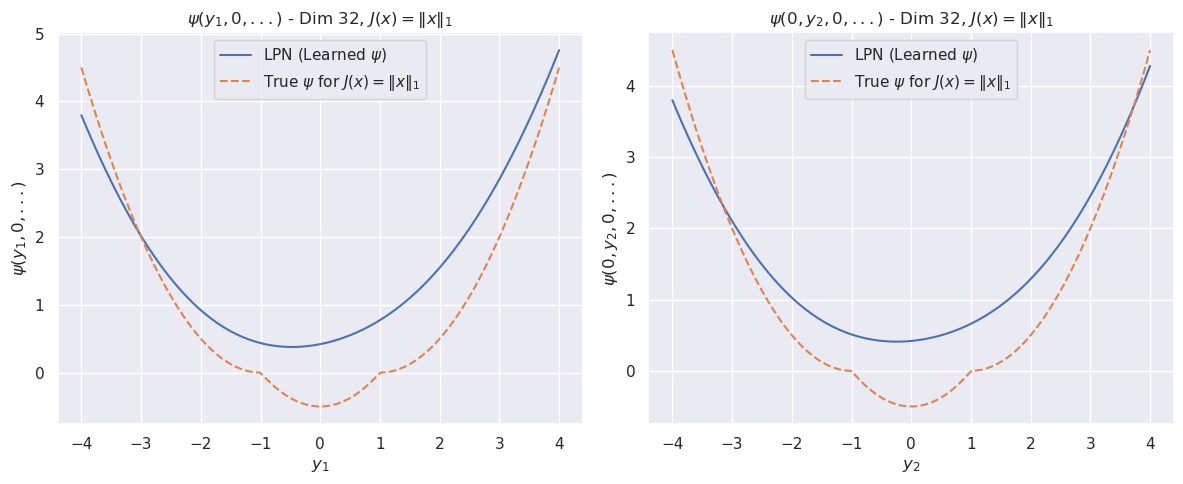

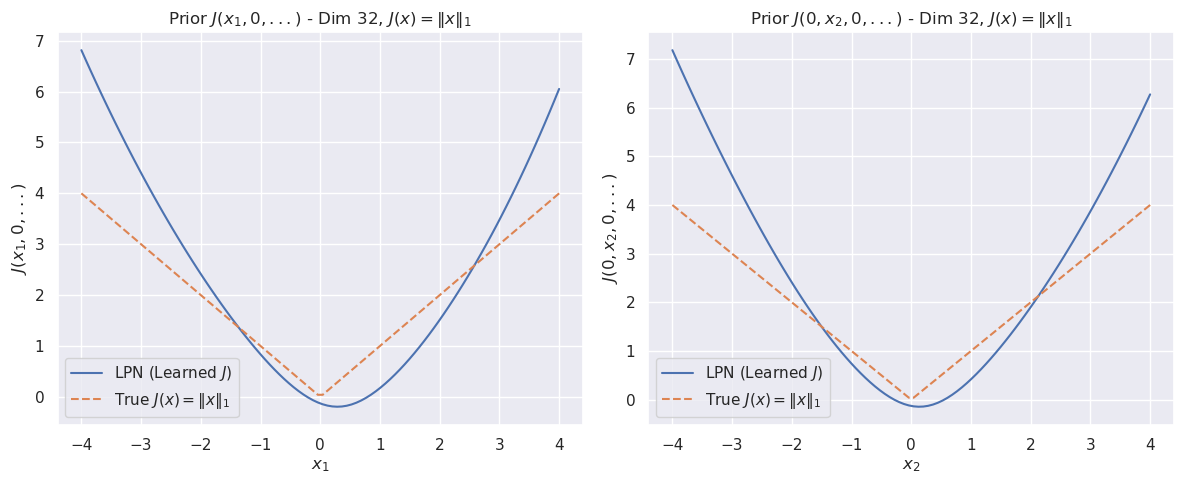

In [8]:
# L1 loss -- Plot
plot_all_quadratic_l1(lpn_model_quad_l1, a_exp, spacing, INVERT_MODE, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

psi_x_k = lpn_model_quad_l1.scalar(x_k_tensor)

y_k_tensor = lpn_model_quad_l1(x_k_tensor)

inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

tensor([[-0.4501,  1.2300, -2.3626,  ...,  1.5933, -1.8447, -0.4189],
        [ 2.4771,  0.0915,  0.6286,  ..., -0.3235,  0.8703, -0.0717],
        [-1.9099,  0.2025,  0.3757,  ...,  0.2034, -0.5047, -1.1258],
        ...,
        [-1.5566,  1.1336,  1.9343,  ...,  0.1295,  0.1936,  0.0910],
        [ 0.0298, -1.8224,  1.4154,  ..., -0.8769, -0.3535,  2.0405],
        [-2.1212, -1.4339, -1.1276,  ..., -0.6250,  0.3088,  0.1241]],
       device='cuda:0')

In [10]:
# --- Step 3: Train 2nd LPN ---
print("\n--- Training Second LPN for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=1, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN for Concave Quadratic Prior ---
iteration 0 loss 49.55706024169922
iteration 0 loss 853.091796875


iteration 500 loss 13.748262405395508


iteration 1000 loss 12.139432907104492


iteration 1500 loss 11.471054077148438


iteration 2000 loss 11.07859992980957


iteration 2500 loss 10.68104076385498


iteration 3000 loss 10.2133150100708


iteration 3500 loss 9.662687301635742


iteration 4000 loss 9.022889137268066


iteration 4500 loss 8.277347564697266


iteration 5000 loss 7.381514072418213


iteration 5500 loss 6.241734504699707


iteration 6000 loss 4.665029048919678


iteration 6500 loss 2.6357712745666504


iteration 7000 loss 1.4329602718353271


iteration 7500 loss 0.9726917743682861


iteration 8000 loss 0.7697139382362366


iteration 8500 loss 0.6838269829750061


iteration 9000 loss 0.6016229391098022


iteration 9500 loss 0.5222359895706177


iteration 10000 loss 0.4478754699230194


iteration 10500 loss 0.3805985152721405


iteration 11000 loss 0.3581378161907196


iteration 11500 loss 0.3402753472328186


iteration 12000 loss 0.32058441638946533


iteration 12500 loss 0.2988751530647278


iteration 13000 loss 0.2752912640571594


iteration 13500 loss 0.25024792551994324


iteration 14000 loss 0.23790983855724335


iteration 14500 loss 0.2298760712146759


iteration 15000 loss 0.22058893740177155


iteration 15500 loss 0.20988304913043976


iteration 16000 loss 0.19765911996364594


iteration 16500 loss 0.18647556006908417


iteration 17000 loss 0.18273311853408813


iteration 17500 loss 0.17872445285320282


iteration 18000 loss 0.17392435669898987


iteration 18500 loss 0.16821254789829254


iteration 19000 loss 0.1614951491355896


iteration 19500 loss 0.1536608189344406


iteration 20000 loss 0.14993435144424438


iteration 20500 loss 0.1474580466747284


iteration 21000 loss 0.14449943602085114


iteration 21500 loss 0.14093434810638428


iteration 22000 loss 0.13666029274463654


iteration 22500 loss 0.1315860003232956


iteration 23000 loss 0.12889550626277924


iteration 23500 loss 0.12746132910251617


iteration 24000 loss 0.12575654685497284


iteration 24500 loss 0.12366103380918503


iteration 25000 loss 0.12109418958425522


iteration 25500 loss 0.1179756224155426


iteration 26000 loss 0.11423040181398392


iteration 26500 loss 0.11276540160179138


iteration 27000 loss 0.11144040524959564


iteration 27500 loss 0.10983212292194366


iteration 28000 loss 0.10785666108131409


iteration 28500 loss 0.10543280839920044


iteration 29000 loss 0.10239207744598389


iteration 29500 loss 0.10157183557748795


iteration 30000 loss 0.10070300102233887


iteration 30500 loss 0.09965676069259644


iteration 31000 loss 0.09836188703775406


iteration 31500 loss 0.09676510840654373


iteration 32000 loss 0.09481082856655121


iteration 32500 loss 0.09290318191051483


iteration 33000 loss 0.09193386882543564


iteration 33500 loss 0.09123875945806503


iteration 34000 loss 0.09040450304746628


iteration 34500 loss 0.0893627405166626


iteration 35000 loss 0.08806300163269043


iteration 35500 loss 0.08645043522119522


iteration 36000 loss 0.10627245903015137


iteration 36500 loss 0.08391950279474258


iteration 37000 loss 0.08310817927122116


iteration 37500 loss 0.08210160583257675


iteration 38000 loss 0.08084297925233841


iteration 38500 loss 0.07925995439291


iteration 39000 loss 0.07812231034040451


iteration 39500 loss 0.07743774354457855


iteration 40000 loss 0.07665558904409409


iteration 40500 loss 0.07567892968654633


iteration 41000 loss 0.074459508061409


iteration 41500 loss 0.07294707745313644


iteration 42000 loss 0.07239456474781036


iteration 42500 loss 0.0718521848320961


iteration 43000 loss 0.07121395319700241


iteration 43500 loss 0.07041443884372711


iteration 44000 loss 0.06941469013690948


iteration 44500 loss 0.06817425042390823


iteration 45000 loss 0.06744425743818283


iteration 45500 loss 0.06698193401098251


iteration 46000 loss 0.06654941290616989


iteration 46500 loss 0.06601922959089279


iteration 47000 loss 0.06535062938928604


iteration 47500 loss 0.06450681388378143


iteration 48000 loss 0.06344511359930038


iteration 48500 loss 0.06317674368619919


iteration 49000 loss 0.0620214082300663


iteration 49500 loss 0.06162824109196663


iteration 50000 loss 0.06115395203232765


iteration 50500 loss 0.060560233891010284


iteration 51000 loss 0.05981583148241043


iteration 51500 loss 0.05888746678829193


iteration 52000 loss 0.2677812874317169


iteration 52500 loss 0.05755780637264252


iteration 53000 loss 0.05721918120980263


iteration 53500 loss 0.056825902312994


iteration 54000 loss 0.05633556470274925


iteration 54500 loss 0.05572228878736496


iteration 55000 loss 0.05496063083410263


iteration 55500 loss 0.05402341112494469


iteration 56000 loss 0.05366436764597893


iteration 56500 loss 0.05336085706949234


iteration 57000 loss 0.053028080612421036


iteration 57500 loss 0.05261573940515518


iteration 58000 loss 0.05210033431649208


iteration 58500 loss 0.051459167152643204


iteration 59000 loss 0.05066782236099243


iteration 59500 loss 0.0503721721470356


iteration 60000 loss 0.050071824342012405


iteration 60500 loss 0.04978602007031441


iteration 61000 loss 0.04943942278623581


iteration 61500 loss 0.04900521785020828


iteration 62000 loss 0.04846065118908882


iteration 62500 loss 0.04778251796960831


iteration 63000 loss 0.04753660038113594


iteration 63500 loss 0.04726038873195648


iteration 64000 loss 0.04702720046043396


iteration 64500 loss 0.04675314947962761


iteration 65000 loss 0.04641273245215416


iteration 65500 loss 0.04598698765039444


iteration 66000 loss 0.045455578714609146


iteration 66500 loss 0.05162908136844635


iteration 67000 loss 0.04479283466935158


iteration 67500 loss 0.044581737369298935


iteration 68000 loss 0.044364579021930695


iteration 68500 loss 0.044100791215896606


iteration 69000 loss 0.04377157613635063


iteration 69500 loss 0.04335998371243477


iteration 70000 loss 0.04284920170903206


iteration 70500 loss 0.042601652443408966


iteration 71000 loss 0.04238487407565117


iteration 71500 loss 0.042199090123176575


iteration 72000 loss 0.04197607934474945


iteration 72500 loss 0.04169761389493942


iteration 73000 loss 0.04134838283061981


iteration 73500 loss 0.04091214761137962


iteration 74000 loss 0.04079851135611534


iteration 74500 loss 0.040528811514377594


iteration 75000 loss 0.04036693647503853


iteration 75500 loss 0.04019732400774956


iteration 76000 loss 0.03999124839901924


iteration 76500 loss 0.03973311558365822


iteration 77000 loss 0.03940857574343681


iteration 77500 loss 0.03900163993239403


iteration 78000 loss 0.038889750838279724


iteration 78500 loss 0.038669634610414505


iteration 79000 loss 0.03852415829896927


iteration 79500 loss 0.03836600109934807


iteration 80000 loss 0.038171764463186264


iteration 80500 loss 0.037927575409412384


iteration 81000 loss 0.0376199334859848


iteration 81500 loss 0.03723463788628578


iteration 82000 loss 0.03718889132142067


iteration 82500 loss 0.037001386284828186


iteration 83000 loss 0.03686658665537834


iteration 83500 loss 0.036719150841236115


iteration 84000 loss 0.03653841093182564


iteration 84500 loss 0.0363115556538105


iteration 85000 loss 0.036026325076818466


iteration 85500 loss 0.03566938266158104


iteration 86000 loss 0.03562086820602417


iteration 86500 loss 0.035459619015455246


iteration 87000 loss 0.03532956540584564


iteration 87500 loss 0.0351799838244915


iteration 88000 loss 0.03499430790543556


iteration 88500 loss 0.03476032242178917


iteration 89000 loss 0.03446609526872635


iteration 89500 loss 0.0344596803188324


iteration 90000 loss 0.03417640179395676


iteration 90500 loss 0.03405478596687317


iteration 91000 loss 0.033938705921173096


iteration 91500 loss 0.03380077704787254


iteration 92000 loss 0.03362848982214928


iteration 92500 loss 0.0334114246070385


iteration 93000 loss 0.03313826024532318


iteration 93500 loss 0.03308189660310745


iteration 94000 loss 0.032860226929187775


iteration 94500 loss 0.032739896327257156


iteration 95000 loss 0.03261186555027962


iteration 95500 loss 0.03245475888252258


iteration 96000 loss 0.03225727006793022


iteration 96500 loss 0.03200828284025192


iteration 97000 loss 0.03206845000386238


iteration 97500 loss 0.03180553391575813


iteration 98000 loss 0.03168990835547447


iteration 98500 loss 0.031588390469551086


iteration 99000 loss 0.03147206827998161


iteration 99500 loss 0.03132849186658859


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.031148027628660202


iteration 100500 loss 0.031125100329518318


iteration 101000 loss 0.03109569661319256


iteration 101500 loss 0.031058048829436302


iteration 102000 loss 0.03100990504026413


iteration 102500 loss 0.030948400497436523


iteration 103000 loss 0.030869970098137856


iteration 103500 loss 0.030770132318139076


iteration 104000 loss 0.03064354695379734


iteration 104500 loss 0.030483542010188103


iteration 105000 loss 0.03028228133916855


iteration 105500 loss 0.030030669644474983


iteration 106000 loss 0.029958294704556465


iteration 106500 loss 0.02990029752254486


iteration 107000 loss 0.029826411977410316


iteration 107500 loss 0.02973235957324505


iteration 108000 loss 0.029612895101308823


iteration 108500 loss 0.029461653903126717


iteration 109000 loss 0.029271068051457405


iteration 109500 loss 0.029032673686742783


iteration 110000 loss 0.028977464884519577


iteration 110500 loss 0.028920713812112808


iteration 111000 loss 0.028848370537161827


iteration 111500 loss 0.02875629812479019


iteration 112000 loss 0.0286394152790308


iteration 112500 loss 0.028491349890828133


iteration 113000 loss 0.028304534032940865


iteration 113500 loss 0.028104936704039574


iteration 114000 loss 0.02804230898618698


iteration 114500 loss 0.027964677661657333


iteration 115000 loss 0.027865923941135406


iteration 115500 loss 0.02774067223072052


iteration 116000 loss 0.027582289651036263


iteration 116500 loss 0.027383269742131233


iteration 117000 loss 0.027285460382699966


iteration 117500 loss 0.02724052034318447


iteration 118000 loss 0.02718331851065159


iteration 118500 loss 0.02711038663983345


iteration 119000 loss 0.02701752632856369


iteration 119500 loss 0.026899486780166626


iteration 120000 loss 0.026749983429908752


iteration 120500 loss 0.02656172402203083


iteration 121000 loss 0.026477187871932983


iteration 121500 loss 0.026435092091560364


iteration 122000 loss 0.026381390169262886


iteration 122500 loss 0.02631288766860962


iteration 123000 loss 0.02622569538652897


iteration 123500 loss 0.026114946231245995


iteration 124000 loss 0.025974608957767487


iteration 124500 loss 0.0257978867739439


iteration 125000 loss 0.025697777047753334


iteration 125500 loss 0.02563628740608692


iteration 126000 loss 0.025557968765497208


iteration 126500 loss 0.025458352640271187


iteration 127000 loss 0.025331975892186165


iteration 127500 loss 0.025172358378767967


iteration 128000 loss 0.02505098469555378


iteration 128500 loss 0.02501397579908371


iteration 129000 loss 0.024967135861516


iteration 129500 loss 0.02490740828216076


iteration 130000 loss 0.024831270799040794


iteration 130500 loss 0.024734405800700188


iteration 131000 loss 0.02461162395775318


iteration 131500 loss 0.024456718936562538


iteration 132000 loss 0.024345574900507927


iteration 132500 loss 0.024288570508360863


iteration 133000 loss 0.02421603910624981


iteration 133500 loss 0.02412380836904049


iteration 134000 loss 0.0240069217979908


iteration 134500 loss 0.023859215900301933


iteration 135000 loss 0.02376791648566723


iteration 135500 loss 0.02373533882200718


iteration 136000 loss 0.023694150149822235


iteration 136500 loss 0.023641590029001236


iteration 137000 loss 0.023574499413371086


iteration 137500 loss 0.023489074781537056


iteration 138000 loss 0.02338062785565853


iteration 138500 loss 0.02324366196990013


iteration 139000 loss 0.02313942275941372


iteration 139500 loss 0.02310076914727688


iteration 140000 loss 0.02305172011256218


iteration 140500 loss 0.022989140823483467


iteration 141000 loss 0.0229093749076128


iteration 141500 loss 0.022808058187365532


iteration 142000 loss 0.022679748013615608


iteration 142500 loss 0.022569680586457253


iteration 143000 loss 0.022540081292390823


iteration 143500 loss 0.022503390908241272


iteration 144000 loss 0.022456523030996323


iteration 144500 loss 0.022396739572286606


iteration 145000 loss 0.02232058160007


iteration 145500 loss 0.022223766893148422


iteration 146000 loss 0.022101091220974922


iteration 146500 loss 0.021996285766363144


iteration 147000 loss 0.02195757068693638


iteration 147500 loss 0.021908409893512726


iteration 148000 loss 0.021845649927854538


iteration 148500 loss 0.021765703335404396


iteration 149000 loss 0.021664151921868324


iteration 149500 loss 0.021535782143473625


iteration 150000 loss 0.021480746567249298


iteration 150500 loss 0.021452495828270912


iteration 151000 loss 0.021416522562503815


iteration 151500 loss 0.0213705375790596


iteration 152000 loss 0.021311845630407333


iteration 152500 loss 0.021237054839730263


iteration 153000 loss 0.021142004057765007


iteration 153500 loss 0.021021775901317596


iteration 154000 loss 0.020964333787560463


iteration 154500 loss 0.020938141271471977


iteration 155000 loss 0.020904889330267906


iteration 155500 loss 0.02086237259209156


iteration 156000 loss 0.02080807089805603


iteration 156500 loss 0.02073884755373001


iteration 157000 loss 0.020650841295719147


iteration 157500 loss 0.0205394197255373


iteration 158000 loss 0.020469631999731064


iteration 158500 loss 0.020445242524147034


iteration 159000 loss 0.02041439525783062


iteration 159500 loss 0.020374996587634087


iteration 160000 loss 0.020324669778347015


iteration 160500 loss 0.020260537043213844


iteration 161000 loss 0.020178981125354767


iteration 161500 loss 0.020075637847185135


iteration 162000 loss 0.019990185275673866


iteration 162500 loss 0.019960232079029083


iteration 163000 loss 0.01992228627204895


iteration 163500 loss 0.01987381838262081


iteration 164000 loss 0.01981203816831112


iteration 164500 loss 0.019733455032110214


iteration 165000 loss 0.019633827731013298


iteration 165500 loss 0.019560039043426514


iteration 166000 loss 0.019538387656211853


iteration 166500 loss 0.019511740654706955


iteration 167000 loss 0.01947771944105625


iteration 167500 loss 0.019434263929724693


iteration 168000 loss 0.019378818571567535


iteration 168500 loss 0.019308222457766533


iteration 169000 loss 0.019218580797314644


iteration 169500 loss 0.01912759430706501


iteration 170000 loss 0.019101712852716446


iteration 170500 loss 0.019078686833381653


iteration 171000 loss 0.01904931850731373


iteration 171500 loss 0.019011782482266426


iteration 172000 loss 0.018963836133480072


iteration 172500 loss 0.018902691081166267


iteration 173000 loss 0.018824908882379532


iteration 173500 loss 0.018726281821727753


iteration 174000 loss 0.01867561601102352


iteration 174500 loss 0.018641840666532516


iteration 175000 loss 0.01859869621694088


iteration 175500 loss 0.018543649464845657


iteration 176000 loss 0.018473513424396515


iteration 176500 loss 0.018384454771876335


iteration 177000 loss 0.018319575116038322


iteration 177500 loss 0.018300523981451988


iteration 178000 loss 0.018276894465088844


iteration 178500 loss 0.018246697261929512


iteration 179000 loss 0.01820807345211506


iteration 179500 loss 0.018158763647079468


iteration 180000 loss 0.0180959515273571


iteration 180500 loss 0.01801617629826069


iteration 181000 loss 0.01793447881937027


iteration 181500 loss 0.01791369542479515


iteration 182000 loss 0.017892392352223396


iteration 182500 loss 0.017865169793367386


iteration 183000 loss 0.017830397933721542


iteration 183500 loss 0.01778596080839634


iteration 184000 loss 0.017729295417666435


iteration 184500 loss 0.017657198011875153


iteration 185000 loss 0.017565816640853882


iteration 185500 loss 0.017542297020554543


iteration 186000 loss 0.017523713409900665


iteration 186500 loss 0.01750003919005394


iteration 187000 loss 0.01746976748108864


iteration 187500 loss 0.017431069165468216


iteration 188000 loss 0.01738164573907852


iteration 188500 loss 0.01731870323419571


iteration 189000 loss 0.017238738015294075


iteration 189500 loss 0.017183439806103706


iteration 190000 loss 0.01716632954776287


iteration 190500 loss 0.01714528165757656


iteration 191000 loss 0.017118385061621666


iteration 191500 loss 0.01708400249481201


iteration 192000 loss 0.017040101811289787


iteration 192500 loss 0.016984088346362114


iteration 193000 loss 0.016912877559661865


iteration 193500 loss 0.01683913543820381


iteration 194000 loss 0.01681690104305744


iteration 194500 loss 0.016790706664323807


iteration 195000 loss 0.016757244244217873


iteration 195500 loss 0.016714535653591156


iteration 196000 loss 0.016660051420331


iteration 196500 loss 0.016590703278779984


iteration 197000 loss 0.016524074599146843


iteration 197500 loss 0.01650739088654518


iteration 198000 loss 0.01648951694369316


iteration 198500 loss 0.016466710716485977


iteration 199000 loss 0.016437508165836334


iteration 199500 loss 0.016400178894400597


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.016352538019418716


iteration 200500 loss 0.016346393153071404


iteration 201000 loss 0.01633857563138008


iteration 201500 loss 0.0163285955786705


iteration 202000 loss 0.016315847635269165


iteration 202500 loss 0.016299623996019363


iteration 203000 loss 0.0162790697067976


iteration 203500 loss 0.016253160312771797


iteration 204000 loss 0.016220806166529655


iteration 204500 loss 0.016180817037820816


iteration 205000 loss 0.01613210327923298


iteration 205500 loss 0.016073860228061676


iteration 206000 loss 0.01600928232073784


iteration 206500 loss 0.01594475284218788


iteration 207000 loss 0.015881353989243507


iteration 207500 loss 0.015818294137716293


iteration 208000 loss 0.015756316483020782


iteration 208500 loss 0.01569642312824726


iteration 209000 loss 0.015635399147868156


iteration 209500 loss 0.015574788674712181


iteration 210000 loss 0.015514732338488102


iteration 210500 loss 0.015455545857548714


iteration 211000 loss 0.015396871604025364


iteration 211500 loss 0.015340655110776424


iteration 212000 loss 0.015282212756574154


iteration 212500 loss 0.015223613940179348


iteration 213000 loss 0.015165490098297596


iteration 213500 loss 0.015108288265764713


iteration 214000 loss 0.015052059665322304


iteration 214500 loss 0.014996160753071308


iteration 215000 loss 0.01494172215461731


iteration 215500 loss 0.014886364340782166


iteration 216000 loss 0.01483052596449852


iteration 216500 loss 0.014776026830077171


iteration 217000 loss 0.014721453189849854


iteration 217500 loss 0.01466808095574379


iteration 218000 loss 0.014614435844123363


iteration 218500 loss 0.014561263844370842


iteration 219000 loss 0.014508401043713093


iteration 219500 loss 0.01445586234331131


iteration 220000 loss 0.014403927139937878


iteration 220500 loss 0.014351324178278446


iteration 221000 loss 0.014300334267318249


iteration 221500 loss 0.014249207451939583


iteration 222000 loss 0.014197985641658306


iteration 222500 loss 0.014146396890282631


iteration 223000 loss 0.014097779057919979


iteration 223500 loss 0.014047455973923206


iteration 224000 loss 0.013997402973473072


iteration 224500 loss 0.013947420753538609


iteration 225000 loss 0.01389862596988678


iteration 225500 loss 0.013849478214979172


iteration 226000 loss 0.013802395202219486


iteration 226500 loss 0.013754984363913536


iteration 227000 loss 0.013707122765481472


iteration 227500 loss 0.013659169897437096


iteration 228000 loss 0.013613390736281872


iteration 228500 loss 0.013566753827035427


iteration 229000 loss 0.013520625419914722


iteration 229500 loss 0.013475402258336544


iteration 230000 loss 0.01343277283012867


iteration 230500 loss 0.01338834036141634


iteration 231000 loss 0.01334340963512659


iteration 231500 loss 0.013299070298671722


iteration 232000 loss 0.013255524449050426


iteration 232500 loss 0.013211831450462341


iteration 233000 loss 0.013168621808290482


iteration 233500 loss 0.013125329278409481


iteration 234000 loss 0.013082174584269524


iteration 234500 loss 0.01303895190358162


iteration 235000 loss 0.012996116653084755


iteration 235500 loss 0.012954081408679485


iteration 236000 loss 0.012912062928080559


iteration 236500 loss 0.012872053310275078


iteration 237000 loss 0.012831772677600384


iteration 237500 loss 0.012790687382221222


iteration 238000 loss 0.012751547619700432


iteration 238500 loss 0.012712502852082253


iteration 239000 loss 0.012671380303800106


iteration 239500 loss 0.012633385136723518


iteration 240000 loss 0.012594562023878098


iteration 240500 loss 0.012555154040455818


iteration 241000 loss 0.012517832219600677


iteration 241500 loss 0.012477895244956017


iteration 242000 loss 0.012438111938536167


iteration 242500 loss 0.012400886975228786


iteration 243000 loss 0.012363279238343239


iteration 243500 loss 0.012324180454015732


iteration 244000 loss 0.012286434881389141


iteration 244500 loss 0.01224888302385807


iteration 245000 loss 0.012212124653160572


iteration 245500 loss 0.012174123898148537


iteration 246000 loss 0.012139122001826763


iteration 246500 loss 0.012102032080292702


iteration 247000 loss 0.012065267190337181


iteration 247500 loss 0.01203057263046503


iteration 248000 loss 0.01199378352612257


iteration 248500 loss 0.011963882483541965


iteration 249000 loss 0.011928231455385685


iteration 249500 loss 0.01189205702394247


iteration 250000 loss 0.01185606513172388


iteration 250500 loss 0.01182024646550417


iteration 251000 loss 0.011784379370510578


iteration 251500 loss 0.011750472709536552


iteration 252000 loss 0.01171615906059742


iteration 252500 loss 0.011680676601827145


iteration 253000 loss 0.011647332459688187


iteration 253500 loss 0.011615319177508354


iteration 254000 loss 0.011583316139876842


iteration 254500 loss 0.011550605297088623


iteration 255000 loss 0.011522348038852215


iteration 255500 loss 0.011488636024296284


iteration 256000 loss 0.011454815044999123


iteration 256500 loss 0.011420550756156445


iteration 257000 loss 0.011387471109628677


iteration 257500 loss 0.011353828944265842


iteration 258000 loss 0.01132007222622633


iteration 258500 loss 0.011288557201623917


iteration 259000 loss 0.011256556026637554


iteration 259500 loss 0.011224983260035515


iteration 260000 loss 0.011193135753273964


iteration 260500 loss 0.011160450056195259


iteration 261000 loss 0.011127850040793419


iteration 261500 loss 0.01109643280506134


iteration 262000 loss 0.011065353639423847


iteration 262500 loss 0.0110338618978858


iteration 263000 loss 0.011002536863088608


iteration 263500 loss 0.010972028598189354


iteration 264000 loss 0.010941047221422195


iteration 264500 loss 0.010909314267337322


iteration 265000 loss 0.010880352929234505


iteration 265500 loss 0.010849732905626297


iteration 266000 loss 0.010818751528859138


iteration 266500 loss 0.010789640247821808


iteration 267000 loss 0.010759829543530941


iteration 267500 loss 0.010729094035923481


iteration 268000 loss 0.010700405575335026


iteration 268500 loss 0.010670646093785763


iteration 269000 loss 0.01064036600291729


iteration 269500 loss 0.010610053315758705


iteration 270000 loss 0.0105842724442482


iteration 270500 loss 0.010554485023021698


iteration 271000 loss 0.01052570529282093


iteration 271500 loss 0.010496987961232662


iteration 272000 loss 0.01046797540038824


iteration 272500 loss 0.010438675060868263


iteration 273000 loss 0.010410436429083347


iteration 273500 loss 0.010382724925875664


iteration 274000 loss 0.0103542385622859


iteration 274500 loss 0.01032559759914875


iteration 275000 loss 0.010299077257514


iteration 275500 loss 0.010271331295371056


iteration 276000 loss 0.01024293527007103


iteration 276500 loss 0.010217028670012951


iteration 277000 loss 0.01018991507589817


iteration 277500 loss 0.01016396377235651


iteration 278000 loss 0.01013749185949564


iteration 278500 loss 0.0101106446236372


iteration 279000 loss 0.010084702633321285


iteration 279500 loss 0.01005745679140091


iteration 280000 loss 0.010031556710600853


iteration 280500 loss 0.010005791671574116


iteration 281000 loss 0.009978476911783218


iteration 281500 loss 0.009953333996236324


iteration 282000 loss 0.009927456267178059


iteration 282500 loss 0.009900649078190327


iteration 283000 loss 0.009875795803964138


iteration 283500 loss 0.009850043803453445


iteration 284000 loss 0.009823441505432129


iteration 284500 loss 0.009799481369554996


iteration 285000 loss 0.00977370422333479


iteration 285500 loss 0.009747456759214401


iteration 286000 loss 0.009723608382046223


iteration 286500 loss 0.009698367677628994


iteration 287000 loss 0.009672529064118862


iteration 287500 loss 0.009648571722209454


iteration 288000 loss 0.009623861871659756


iteration 288500 loss 0.009598643518984318


iteration 289000 loss 0.0095762237906456


iteration 289500 loss 0.009551046416163445


iteration 290000 loss 0.009526729583740234


iteration 290500 loss 0.00950364675372839


iteration 291000 loss 0.009478668682277203


iteration 291500 loss 0.009455278515815735


iteration 292000 loss 0.009431817568838596


iteration 292500 loss 0.009407120756804943


iteration 293000 loss 0.009383957833051682


iteration 293500 loss 0.009360493160784245


iteration 294000 loss 0.009336337447166443


iteration 294500 loss 0.009312263689935207


iteration 295000 loss 0.009288991801440716


iteration 295500 loss 0.009265723638236523


iteration 296000 loss 0.009242177940905094


iteration 296500 loss 0.009218373335897923


iteration 297000 loss 0.009195603430271149


iteration 297500 loss 0.00917379092425108


iteration 298000 loss 0.009150378406047821


iteration 298500 loss 0.009129693731665611


iteration 299000 loss 0.009106959216296673


iteration 299500 loss 0.009084952995181084


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.009063061326742172


iteration 300500 loss 0.009060653857886791


iteration 301000 loss 0.009057831019163132


iteration 301500 loss 0.009054554626345634


iteration 302000 loss 0.009050819091498852


iteration 302500 loss 0.009046610444784164


iteration 303000 loss 0.009041897021234035


iteration 303500 loss 0.009036798030138016


iteration 304000 loss 0.009031398221850395


iteration 304500 loss 0.009025751613080502


iteration 305000 loss 0.009019910357892513


iteration 305500 loss 0.009013907983899117


iteration 306000 loss 0.009007836692035198


iteration 306500 loss 0.009001794271171093


iteration 307000 loss 0.00899580493569374


iteration 307500 loss 0.00898987241089344


iteration 308000 loss 0.008983990177512169


iteration 308500 loss 0.008978139609098434


iteration 309000 loss 0.008972336538136005


iteration 309500 loss 0.008966553956270218


iteration 310000 loss 0.008960811421275139


iteration 310500 loss 0.008955102413892746


iteration 311000 loss 0.00894942320883274


iteration 311500 loss 0.008943762630224228


iteration 312000 loss 0.008938134647905827


iteration 312500 loss 0.008932520635426044


iteration 313000 loss 0.008926937356591225


iteration 313500 loss 0.008921370841562748


iteration 314000 loss 0.008915831334888935


iteration 314500 loss 0.008910306729376316


iteration 315000 loss 0.008904803544282913


iteration 315500 loss 0.008899325504899025


iteration 316000 loss 0.008893853984773159


iteration 316500 loss 0.008888407610356808


iteration 317000 loss 0.008882977068424225


iteration 317500 loss 0.00887756422162056


iteration 318000 loss 0.008872166275978088


iteration 318500 loss 0.008866771124303341


iteration 319000 loss 0.008861408568918705


iteration 319500 loss 0.008856046944856644


iteration 320000 loss 0.008850714191794395


iteration 320500 loss 0.008845380507409573


iteration 321000 loss 0.00884006917476654


iteration 321500 loss 0.008834770880639553


iteration 322000 loss 0.008829484693706036


iteration 322500 loss 0.008824214339256287


iteration 323000 loss 0.008818951435387135


iteration 323500 loss 0.008813705295324326


iteration 324000 loss 0.00880847405642271


iteration 324500 loss 0.008803248405456543


iteration 325000 loss 0.008798033930361271


iteration 325500 loss 0.008792834356427193


iteration 326000 loss 0.008787645027041435


iteration 326500 loss 0.008782466873526573


iteration 327000 loss 0.008777298033237457


iteration 327500 loss 0.008772138506174088


iteration 328000 loss 0.00876699760556221


iteration 328500 loss 0.008761860430240631


iteration 329000 loss 0.008756730705499649


iteration 329500 loss 0.008751616813242435


iteration 330000 loss 0.008746509440243244


iteration 330500 loss 0.008741411380469799


iteration 331000 loss 0.008736311458051205


iteration 331500 loss 0.008731231093406677


iteration 332000 loss 0.00872616283595562


iteration 332500 loss 0.00872108992189169


iteration 333000 loss 0.008716041222214699


iteration 333500 loss 0.008710996247828007


iteration 334000 loss 0.008705961517989635


iteration 334500 loss 0.008700933307409286


iteration 335000 loss 0.00869591161608696


iteration 335500 loss 0.008690902031958103


iteration 336000 loss 0.008685912936925888


iteration 336500 loss 0.008680921047925949


iteration 337000 loss 0.008675933815538883


iteration 337500 loss 0.008670952171087265


iteration 338000 loss 0.008665986359119415


iteration 338500 loss 0.008661029860377312


iteration 339000 loss 0.00865608174353838


iteration 339500 loss 0.008651135489344597


iteration 340000 loss 0.008646205067634583


iteration 340500 loss 0.008641276508569717


iteration 341000 loss 0.00863635167479515


iteration 341500 loss 0.008631438948214054


iteration 342000 loss 0.008626537397503853


iteration 342500 loss 0.008621638640761375


iteration 343000 loss 0.008616751059889793


iteration 343500 loss 0.008611872792243958


iteration 344000 loss 0.008606997318565845


iteration 344500 loss 0.008602123707532883


iteration 345000 loss 0.008597273379564285


iteration 345500 loss 0.008592426776885986


iteration 346000 loss 0.008587576448917389


iteration 346500 loss 0.008582736365497112


iteration 347000 loss 0.008577904663980007


iteration 347500 loss 0.008573072962462902


iteration 348000 loss 0.008568260818719864


iteration 348500 loss 0.00856345146894455


iteration 349000 loss 0.008558644913136959


iteration 349500 loss 0.008553843013942242


iteration 350000 loss 0.008549041114747524


iteration 350500 loss 0.0085442578420043


iteration 351000 loss 0.008539477363228798


iteration 351500 loss 0.008534702472388744


iteration 352000 loss 0.00852992944419384


iteration 352500 loss 0.008525167591869831


iteration 353000 loss 0.008520402014255524


iteration 353500 loss 0.008515650406479836


iteration 354000 loss 0.008510908111929893


iteration 354500 loss 0.008506163954734802


iteration 355000 loss 0.008501434698700905


iteration 355500 loss 0.008496707305312157


iteration 356000 loss 0.008491984568536282


iteration 356500 loss 0.008487261831760406


iteration 357000 loss 0.008482553996145725


iteration 357500 loss 0.008477853611111641


iteration 358000 loss 0.008473150432109833


iteration 358500 loss 0.008468459360301495


iteration 359000 loss 0.008463776670396328


iteration 359500 loss 0.00845909770578146


iteration 360000 loss 0.008454420603811741


iteration 360500 loss 0.008449750952422619


iteration 361000 loss 0.008445094339549541


iteration 361500 loss 0.008440435864031315


iteration 362000 loss 0.00843578390777111


iteration 362500 loss 0.008431143127381802


iteration 363000 loss 0.008426490239799023


iteration 363500 loss 0.008421862497925758


iteration 364000 loss 0.008417232893407345


iteration 364500 loss 0.008412613533437252


iteration 365000 loss 0.00840799417346716


iteration 365500 loss 0.008403373882174492


iteration 366000 loss 0.008398770354688168


iteration 366500 loss 0.008394170552492142


iteration 367000 loss 0.00838957168161869


iteration 367500 loss 0.008384974673390388


iteration 368000 loss 0.008380386047065258


iteration 368500 loss 0.008375810459256172


iteration 369000 loss 0.008371228352189064


iteration 369500 loss 0.008366654627025127


iteration 370000 loss 0.008362086489796638


iteration 370500 loss 0.00835752859711647


iteration 371000 loss 0.008352971635758877


iteration 371500 loss 0.008348420262336731


iteration 372000 loss 0.00834386982023716


iteration 372500 loss 0.008339332416653633


iteration 373000 loss 0.008334788493812084


iteration 373500 loss 0.008330254815518856


iteration 374000 loss 0.00832572765648365


iteration 374500 loss 0.008321203291416168


iteration 375000 loss 0.008316687308251858


iteration 375500 loss 0.008312173187732697


iteration 376000 loss 0.008307660929858685


iteration 376500 loss 0.008303164504468441


iteration 377000 loss 0.008298663422465324


iteration 377500 loss 0.008294166065752506


iteration 378000 loss 0.008289683610200882


iteration 378500 loss 0.008285200223326683


iteration 379000 loss 0.008280716836452484


iteration 379500 loss 0.008276249282062054


iteration 380000 loss 0.0082717789337039


iteration 380500 loss 0.008267318829894066


iteration 381000 loss 0.008262855000793934


iteration 381500 loss 0.008258403278887272


iteration 382000 loss 0.008253953419625759


iteration 382500 loss 0.00824950821697712


iteration 383000 loss 0.008245065808296204


iteration 383500 loss 0.008240637369453907


iteration 384000 loss 0.008236202411353588


iteration 384500 loss 0.00823177583515644


iteration 385000 loss 0.008227366022765636


iteration 385500 loss 0.008222940377891064


iteration 386000 loss 0.008218534290790558


iteration 386500 loss 0.008214120753109455


iteration 387000 loss 0.008209731429815292


iteration 387500 loss 0.008205332793295383


iteration 388000 loss 0.008200936019420624


iteration 388500 loss 0.008196549490094185


iteration 389000 loss 0.008192162029445171


iteration 389500 loss 0.008187780156731606


iteration 390000 loss 0.008183405734598637


iteration 390500 loss 0.008179030381143093


iteration 391000 loss 0.008174651302397251


iteration 391500 loss 0.008170290850102901


iteration 392000 loss 0.008165935985744


iteration 392500 loss 0.008161568082869053


iteration 393000 loss 0.008157216012477875


iteration 393500 loss 0.008152869530022144


iteration 394000 loss 0.008148524910211563


iteration 394500 loss 0.008144180290400982


iteration 395000 loss 0.008139846846461296


iteration 395500 loss 0.008135514333844185


iteration 396000 loss 0.008131185546517372


iteration 396500 loss 0.008126863278448582


iteration 397000 loss 0.008122541010379791


iteration 397500 loss 0.008118226192891598


iteration 398000 loss 0.008113909512758255


iteration 398500 loss 0.00810960866510868


iteration 399000 loss 0.008105296641588211


iteration 399500 loss 0.008100992068648338


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.008096694946289062


iteration 400500 loss 0.008096379227936268


iteration 401000 loss 0.008096052333712578


iteration 401500 loss 0.008095725439488888


iteration 402000 loss 0.008095387369394302


iteration 402500 loss 0.008095050230622292


iteration 403000 loss 0.008094705641269684


iteration 403500 loss 0.008094366639852524


iteration 404000 loss 0.008094019256532192


iteration 404500 loss 0.008093676529824734


iteration 405000 loss 0.00809332262724638


iteration 405500 loss 0.00809298362582922


iteration 406000 loss 0.00809263251721859


iteration 406500 loss 0.008092290721833706


iteration 407000 loss 0.008091955445706844


iteration 407500 loss 0.00809161365032196


iteration 408000 loss 0.008091269060969353


iteration 408500 loss 0.00809092354029417


iteration 409000 loss 0.008090594783425331


iteration 409500 loss 0.008090250194072723


iteration 410000 loss 0.008089910261332989


iteration 410500 loss 0.008089577779173851


iteration 411000 loss 0.008089232258498669


iteration 411500 loss 0.00808890163898468


iteration 412000 loss 0.008088568225502968


iteration 412500 loss 0.008088231086730957


iteration 413000 loss 0.008087891153991222


iteration 413500 loss 0.008087558671832085


iteration 414000 loss 0.0080872206017375


iteration 414500 loss 0.008086889050900936


iteration 415000 loss 0.008086553774774075


iteration 415500 loss 0.008086222223937511


iteration 416000 loss 0.008085888810455799


iteration 416500 loss 0.008085557259619236


iteration 417000 loss 0.008085221983492374


iteration 417500 loss 0.008084893226623535


iteration 418000 loss 0.008084557019174099


iteration 418500 loss 0.008084231056272984


iteration 419000 loss 0.008083898574113846


iteration 419500 loss 0.008083567023277283


iteration 420000 loss 0.008083239197731018


iteration 420500 loss 0.008082909509539604


iteration 421000 loss 0.008082576096057892


iteration 421500 loss 0.008082244545221329


iteration 422000 loss 0.008081918582320213


iteration 422500 loss 0.008081579580903053


iteration 423000 loss 0.00808126013725996


iteration 423500 loss 0.008080932311713696


iteration 424000 loss 0.008080599829554558


iteration 424500 loss 0.008080275729298592


iteration 425000 loss 0.008079946972429752


iteration 425500 loss 0.00807962380349636


iteration 426000 loss 0.008079297840595245


iteration 426500 loss 0.008078968152403831


iteration 427000 loss 0.008078644052147865


iteration 427500 loss 0.008078317157924175


iteration 428000 loss 0.00807798933237791


iteration 428500 loss 0.008077660575509071


iteration 429000 loss 0.00807733740657568


iteration 429500 loss 0.008077014237642288


iteration 430000 loss 0.008076682686805725


iteration 430500 loss 0.008076362311840057


iteration 431000 loss 0.008076035417616367


iteration 431500 loss 0.008075719699263573


iteration 432000 loss 0.008075389079749584


iteration 432500 loss 0.008075066842138767


iteration 433000 loss 0.008074741810560226


iteration 433500 loss 0.008074418641626835


iteration 434000 loss 0.008074087090790272


iteration 434500 loss 0.008073774166405201


iteration 435000 loss 0.008073454722762108


iteration 435500 loss 0.008073127828538418


iteration 436000 loss 0.008072801865637302


iteration 436500 loss 0.00807248242199421


iteration 437000 loss 0.008072162978351116


iteration 437500 loss 0.0080718407407403


iteration 438000 loss 0.008071514777839184


iteration 438500 loss 0.008071190677583218


iteration 439000 loss 0.008070872165262699


iteration 439500 loss 0.008070549927651882


iteration 440000 loss 0.008070236071944237


iteration 440500 loss 0.00806991383433342


iteration 441000 loss 0.008069589734077454


iteration 441500 loss 0.008069267496466637


iteration 442000 loss 0.008068952709436417


iteration 442500 loss 0.008068634197115898


iteration 443000 loss 0.008068311028182507


iteration 443500 loss 0.008067990653216839


iteration 444000 loss 0.008067671209573746


iteration 444500 loss 0.008067352697253227


iteration 445000 loss 0.008067033253610134


iteration 445500 loss 0.008066722191870213


iteration 446000 loss 0.008066395297646523


iteration 446500 loss 0.008066083304584026


iteration 447000 loss 0.008065763860940933


iteration 447500 loss 0.008065441623330116


iteration 448000 loss 0.008065122179687023


iteration 448500 loss 0.00806480273604393


iteration 449000 loss 0.00806448794901371


iteration 449500 loss 0.008064172230660915


iteration 450000 loss 0.008063854649662971


iteration 450500 loss 0.008063538931310177


iteration 451000 loss 0.008063221350312233


iteration 451500 loss 0.008062899112701416


iteration 452000 loss 0.00806258711963892


iteration 452500 loss 0.008062269538640976


iteration 453000 loss 0.008061954751610756


iteration 453500 loss 0.008061638101935387


iteration 454000 loss 0.008061317726969719


iteration 454500 loss 0.00806100107729435


iteration 455000 loss 0.008060685358941555


iteration 455500 loss 0.008060374297201633


iteration 456000 loss 0.008060052059590816


iteration 456500 loss 0.008059742860496044


iteration 457000 loss 0.008059422485530376


iteration 457500 loss 0.00805911235511303


iteration 458000 loss 0.008058792911469936


iteration 458500 loss 0.008058475330471992


iteration 459000 loss 0.008058161474764347


iteration 459500 loss 0.00805785320699215


iteration 460000 loss 0.008057528175413609


iteration 460500 loss 0.008057218976318836


iteration 461000 loss 0.008056899532675743


iteration 461500 loss 0.008056588470935822


iteration 462000 loss 0.00805627554655075


iteration 462500 loss 0.008055961690843105


iteration 463000 loss 0.008055649697780609


iteration 463500 loss 0.008055335842072964


iteration 464000 loss 0.008055017329752445


iteration 464500 loss 0.008054707199335098


iteration 465000 loss 0.008054397068917751


iteration 465500 loss 0.008054083213210106


iteration 466000 loss 0.008053776808083057


iteration 466500 loss 0.00805345457047224


iteration 467000 loss 0.008053143508732319


iteration 467500 loss 0.008052821271121502


iteration 468000 loss 0.008052521385252476


iteration 468500 loss 0.008052206598222256


iteration 469000 loss 0.00805189274251461


iteration 469500 loss 0.008051578886806965


iteration 470000 loss 0.008051270619034767


iteration 470500 loss 0.008050959557294846


iteration 471000 loss 0.008050644770264626


iteration 471500 loss 0.008050333708524704


iteration 472000 loss 0.00805001799017191


iteration 472500 loss 0.008049716241657734


iteration 473000 loss 0.00804939679801464


iteration 473500 loss 0.008049087598919868


iteration 474000 loss 0.008048776537179947


iteration 474500 loss 0.008048471994698048


iteration 475000 loss 0.008048159070312977


iteration 475500 loss 0.00804784707725048


iteration 476000 loss 0.008047536946833134


iteration 476500 loss 0.008047226816415787


iteration 477000 loss 0.008046913892030716


iteration 477500 loss 0.00804660189896822


iteration 478000 loss 0.00804629921913147


iteration 478500 loss 0.008045990951359272


iteration 479000 loss 0.00804567988961935


iteration 479500 loss 0.008045361377298832


iteration 480000 loss 0.008045060560107231


iteration 480500 loss 0.008044752292335033


iteration 481000 loss 0.008044436573982239


iteration 481500 loss 0.008044132962822914


iteration 482000 loss 0.008043820038437843


iteration 482500 loss 0.008043511770665646


iteration 483000 loss 0.008043204434216022


iteration 483500 loss 0.008042890578508377


iteration 484000 loss 0.008042591623961926


iteration 484500 loss 0.008042280562222004


iteration 485000 loss 0.008041970431804657


iteration 485500 loss 0.008041659370064735


iteration 486000 loss 0.008041356690227985


iteration 486500 loss 0.00804104469716549


iteration 487000 loss 0.008040741086006165


iteration 487500 loss 0.008040431886911392


iteration 488000 loss 0.00804012268781662


iteration 488500 loss 0.008039814420044422


iteration 489000 loss 0.008039506152272224


iteration 489500 loss 0.008039192296564579


iteration 490000 loss 0.008038900792598724


iteration 490500 loss 0.008038591593503952


iteration 491000 loss 0.008038281463086605


iteration 491500 loss 0.008037969470024109


iteration 492000 loss 0.008037667721509933


iteration 492500 loss 0.008037357591092587


iteration 493000 loss 0.00803705770522356


iteration 493500 loss 0.008036750368773937


iteration 494000 loss 0.008036439307034016


iteration 494500 loss 0.008036140352487564


iteration 495000 loss 0.008035829290747643


iteration 495500 loss 0.008035525679588318


iteration 496000 loss 0.00803521741181612


iteration 496500 loss 0.00803491659462452


iteration 497000 loss 0.008034612983465195


iteration 497500 loss 0.008034304715692997


iteration 498000 loss 0.008034001104533672


iteration 498500 loss 0.008033694699406624


iteration 499000 loss 0.008033398538827896


iteration 499500 loss 0.0080330865457654


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


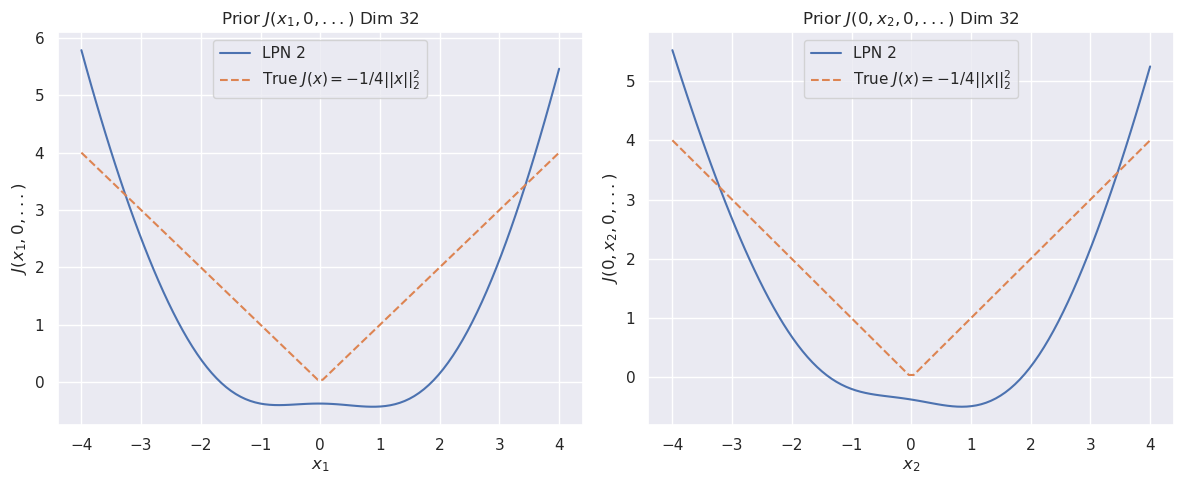

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)